In [1]:
# use dream_proj conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr, spearmanr, gmean
import statsmodels.formula.api as smf
%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data


# Palettes

In [9]:
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-1])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

<Axes: ylabel='value'>

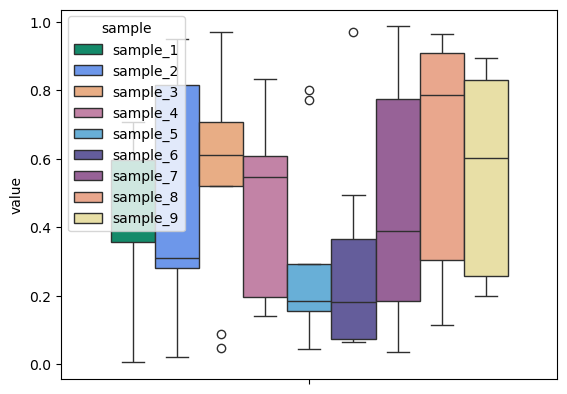

In [7]:
# create random data with 8 samples
np.random.seed(42)
data = np.random.rand(9, 9)
df = pd.DataFrame(data, columns=['sample_{}'.format(i) for i in range(1, 10)])
# pivot long
df = df.melt(var_name='sample', value_name='value')
sns.boxplot(data = df, hue = 'sample', y = 'value', palette = my_categorical_palette)

# Read data

In [2]:
loader = read_data.DatasetLoader("CPTAC-3", load_methylation=False, load_expression=True)
cptac_expr, cptac_mut, _ = loader.load_dataset()
# pre-process
cptac_expr.scale_by_total_seq_depth()
cptac_expr.log_scale_expr()
# get dream gene expression
cptac_expr.get_dream_gene_expression(
    #row_limiting_query = "harmine_dna_repair_up == 1 and indy_dna_repair_up == 1"
    )   
cptac_expr.dream_expression['mean_dream_reg_expr'] = cptac_expr.dream_expression[
    cptac_expr.dream_regulated_genes_w_expression
    ].mean(axis=1)
# select non metadata columns
cptac_expr.dream_expression['mean_overall_expr'] = cptac_expr.expression_df[
    [c for c in cptac_expr.expression_df.columns if c not in cptac_expr.meta_cols]
    ].mean(axis=1)
# get residual
ols = smf.ols(
    'mean_dream_reg_expr ~ total_seq_depth * n_genes_expressed',# * sample_type',
    data=cptac_expr.dream_expression
    ).fit()
cptac_expr.dream_expression['mean_dream_reg_expr_resid'] = ols.resid

Loading dataset: CPTAC-3
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_uterus_ucec_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores_no_DREAM_reg_genes.parquet
Loaded metadata for CPTAC-3
Created ExpressionDataset for CPTAC-3
Created MutationDataset for CPTAC-3
Did not need to convert DREAM genes
Found 322 DREAM genes with expression


In [4]:
cptac_expr.expression_df.tissue.value_counts()

tissue
Lung        649
Kidney      521
Uterus      479
Mouth       234
Pancreas    220
Brain       106
Name: count, dtype: int64

In [6]:
cptac_expr.expression_df.cancer_type.value_counts()

cancer_type
Renal cell carcinoma           521
Endometrioid adenocarcinoma    479
Adenocarcinoma                 443
Squamous cell carcinoma        440
Infiltrating duct carcinoma    220
Glioblastoma                   104
Oligodendroglioma                2
Name: count, dtype: int64

# DREAM expression vs. mutation burden

### Get DREAM regulated expression

In [4]:
cptac_expr.dream_expression.groupby('cancer_type')[
    ['mean_dream_reg_expr_resid', 'mean_dream_reg_expr']
    ].corr(method = 'spearman')

mean_dream_reg_expr_resid  \
cancer_type                                                                        
Adenocarcinoma              mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.453228   
Endometrioid adenocarcinoma mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.918971   
Glioblastoma                mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.985405   
Infiltrating duct carcinoma mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.688204   
Oligodendroglioma           mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         1.000000   
Renal cell carcinoma        mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.038705   
Squamous cell carcinoma     mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.880711   

                                                       mean_dream_reg_expr  
cancer_type                                                                 
Adenocarcinoma              mean_dream_reg_expr_resid             0.453228  
                            mean_dream_reg_expr                   1.000000  
Endometrioid adenocarcinoma mean_dream_reg_expr_resid             0.918971  
                            mean_dream_reg_expr                   1.000000  
Glioblastoma                mean_dream_reg_expr_resid             0.985405  
                            mean_dream_reg_expr                   1.000000  
Infiltrating duct carcinoma mean_dream_reg_expr_resid             0.688204  
                            mean_dream_reg_expr                   1.000000  
Oligodendroglioma           mean_dream_reg_expr_resid             1.000000  
                            mean_dream_reg_expr                   1.000000  
Renal cell carcinoma        mean_dream_reg_expr_resid             0.038705  
                            mean_dream_reg_expr                   1.000000  
Squamous cell carcinoma     mean_dream_reg_expr_resid             0.880711  
                            mean_dream_reg_expr                   1.000000

##### Dream regulated genes are upregulated in tumors

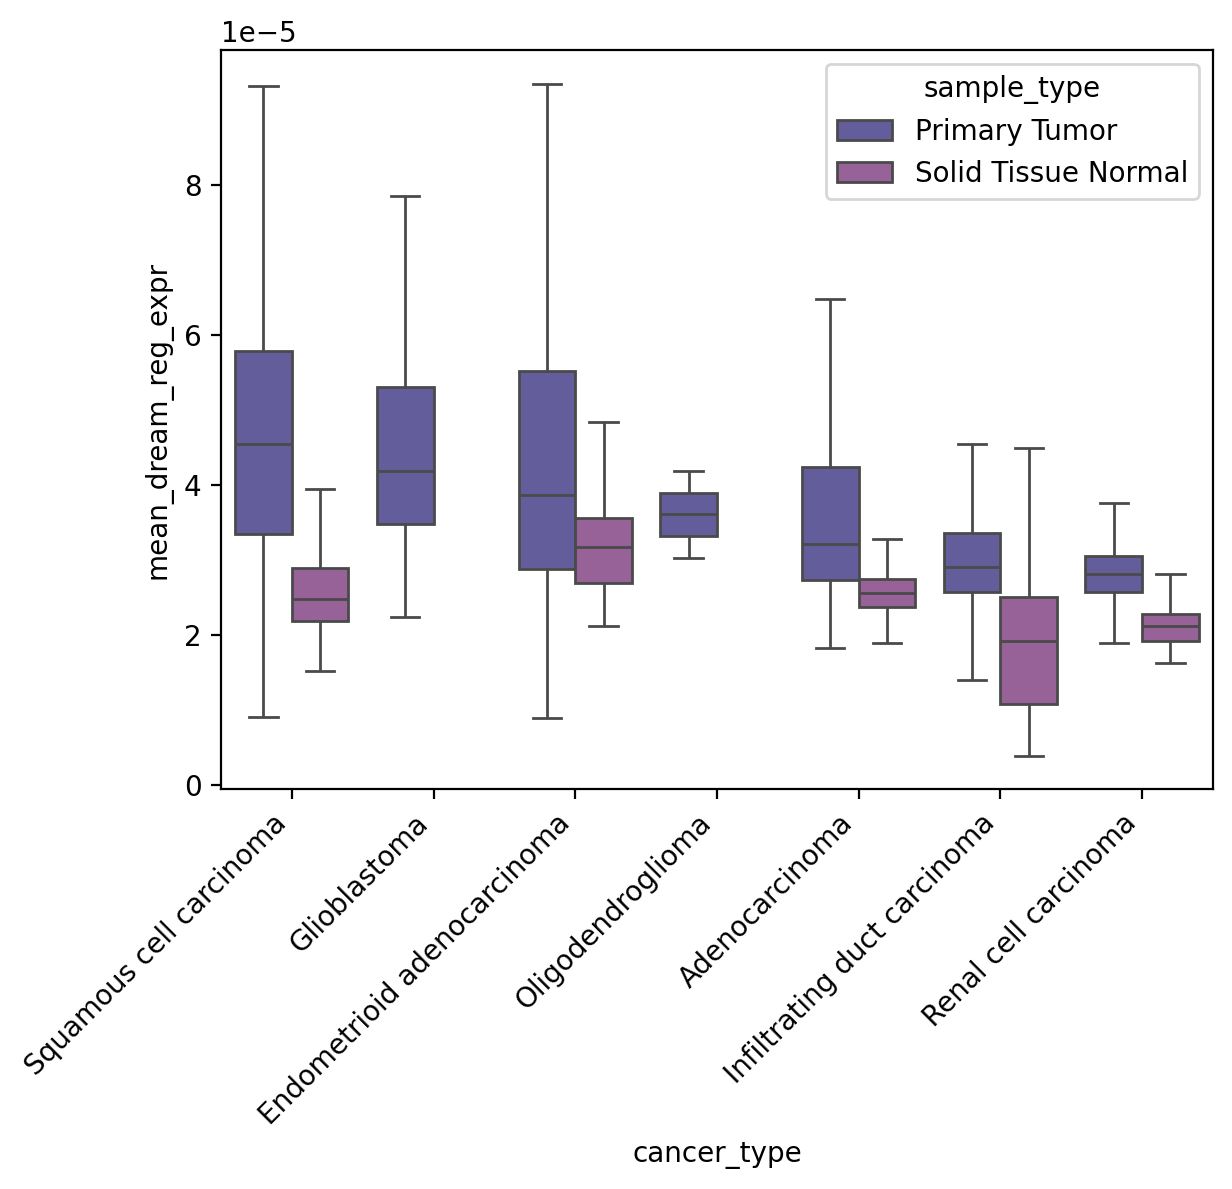

In [6]:
# order by median dream expression in all samples
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('cancer_type')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression,
    x = 'cancer_type', 
    y = 'mean_dream_reg_expr',
    hue = 'sample_type',
    order = plot_order,
    showfliers = False,
    palette=my_categorical_palette[5:7]
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

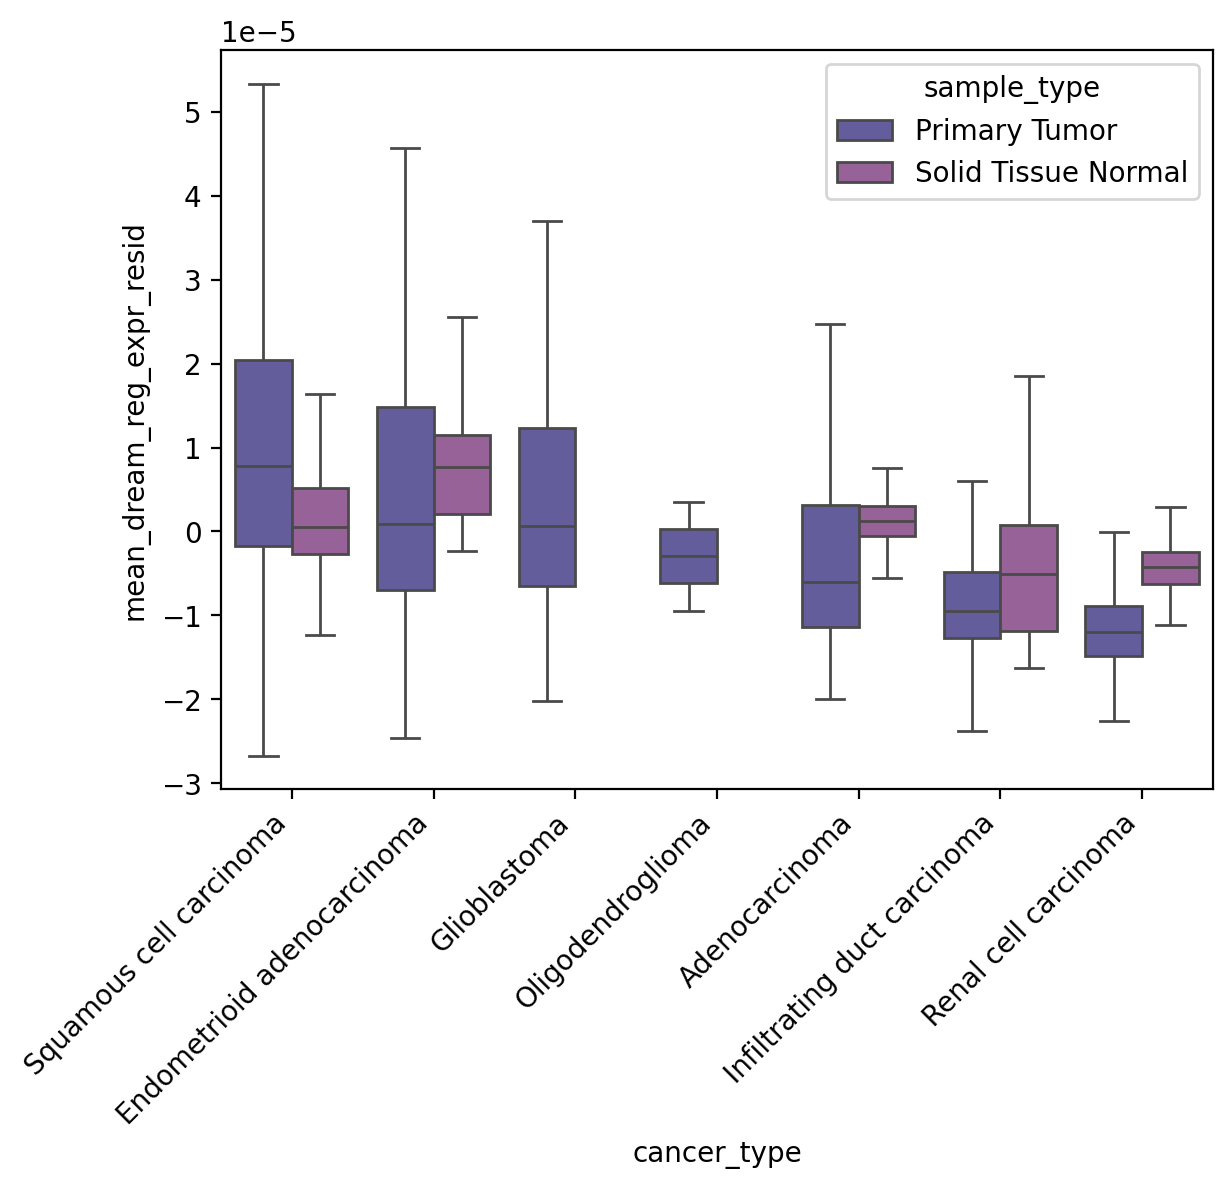

In [7]:
# order by median dream expression in all samples
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('cancer_type')['mean_dream_reg_expr_resid'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression,
    x = 'cancer_type', 
    y = 'mean_dream_reg_expr_resid',
    hue = 'sample_type',
    order = plot_order,
    showfliers = False,
    palette=my_categorical_palette[5:7]
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

<Axes: xlabel='tissue', ylabel='mean_dream_reg_expr'>

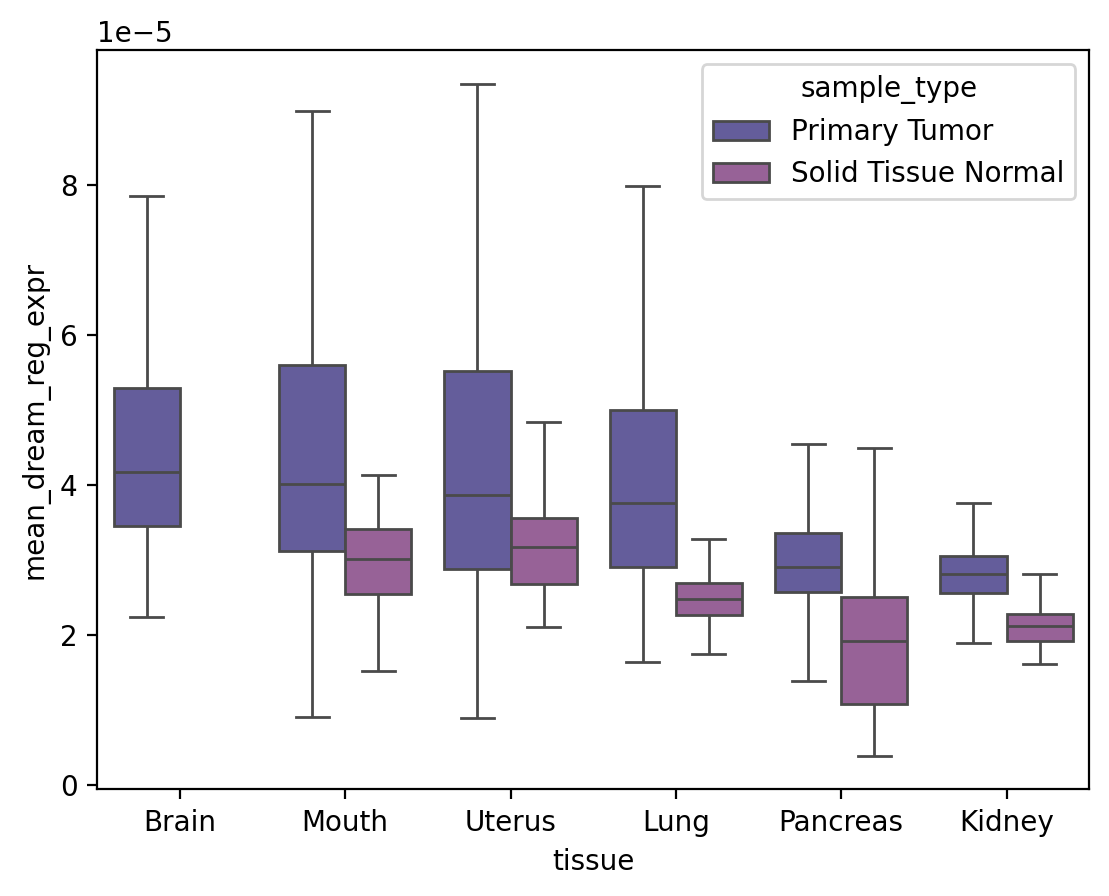

In [9]:
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('tissue')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression, 
    x = 'tissue', 
    y = 'mean_dream_reg_expr', 
    hue = 'sample_type',
    order = plot_order,
    showfliers=False,
    palette=my_categorical_palette[5:7]
    )

<Axes: xlabel='tissue', ylabel='mean_dream_reg_expr_resid'>

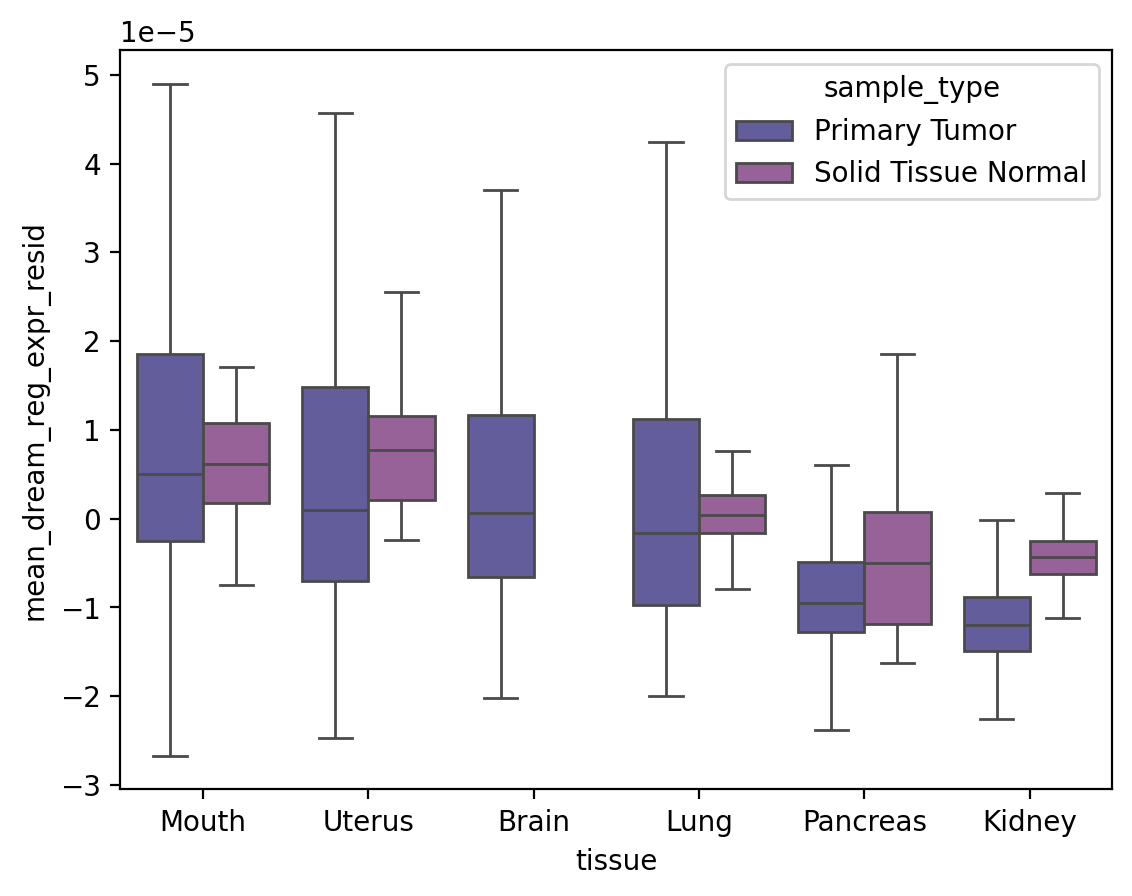

In [10]:
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('tissue')['mean_dream_reg_expr_resid'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression, 
    x = 'tissue', 
    y = 'mean_dream_reg_expr_resid', 
    hue = 'sample_type',
    order = plot_order,
    showfliers=False,
    palette=my_categorical_palette[5:7]
    )

##### Dream regulated gene expression does not change with age

In [68]:
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
spearmanr(normal_tissue_dream_expr['age_at_index'],normal_tissue_dream_expr['mean_dream_reg_expr'], nan_policy='omit')

SignificanceResult(statistic=0.03211155830251521, pvalue=0.42779150206456307)

In [70]:
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
spearmanr(normal_tissue_dream_expr['age_at_index'],normal_tissue_dream_expr['mean_dream_reg_expr_resid'], nan_policy='omit')

SignificanceResult(statistic=0.037834638601854306, pvalue=0.35009846196322614)

In [69]:
tumor_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'")
spearmanr(tumor_tissue_dream_expr['age_at_index'],tumor_tissue_dream_expr['mean_dream_reg_expr'], nan_policy='omit')

SignificanceResult(statistic=-0.03169925326633488, pvalue=0.21646906214749903)

In [71]:
tumor_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'")
spearmanr(tumor_tissue_dream_expr['age_at_index'],tumor_tissue_dream_expr['mean_dream_reg_expr_resid'], nan_policy='omit')

SignificanceResult(statistic=-0.008558835191777173, pvalue=0.7386542051638612)

### Deconvolving cell-cyle

##### With DREAM reg genes in

In [40]:
# deconvolutuion was done in /cellar/users/zkoch/dream/notebooks/010824_cellCycle_deconv.ipynb
cell_cycle_scores = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet')
# merge with dream expression
cptac_expr.dream_expression = cptac_expr.dream_expression.merge(cell_cycle_scores, left_index=True, right_index=True)

In [41]:
corr_by_sample_type = cptac_expr.dream_expression.groupby('sample_type')[['mean_dream_reg_expr', 'median_dream_reg_expr', 'S_score', 'G2M_score']].corr(method='spearman')
corr_by_sample_type

mean_dream_reg_expr  \
sample_type                                                      
Primary Tumor       mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.988387   
                    S_score                           0.669430   
                    G2M_score                         0.870718   
Solid Tissue Normal mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.938112   
                    S_score                          -0.204374   
                    G2M_score                         0.024895   

                                           median_dream_reg_expr   S_score  \
sample_type                                                                  
Primary Tumor       mean_dream_reg_expr                 0.988387  0.669430   
                    median_dream_reg_expr               1.000000  0.643426   
                    S_score                             0.643426  1.000000   
                    G2M_score                           0.878172  0.659201   
Solid Tissue Normal mean_dream_reg_expr                 0.938112 -0.204374   
                    median_dream_reg_expr               1.000000 -0.113728   
                    S_score                            -0.113728  1.000000   
                    G2M_score                           0.108041  0.255492   

                                           G2M_score  
sample_type                                           
Primary Tumor       mean_dream_reg_expr     0.870718  
                    median_dream_reg_expr   0.878172  
                    S_score                 0.659201  
                    G2M_score               1.000000  
Solid Tissue Normal mean_dream_reg_expr     0.024895  
                    median_dream_reg_expr   0.108041  
                    S_score                 0.255492  
                    G2M_score               1.000000

In [108]:
cptac_mut.mutation_burden.shape

(1272, 8)

Text(-40, 5, '$\\rho$ = -0.11')

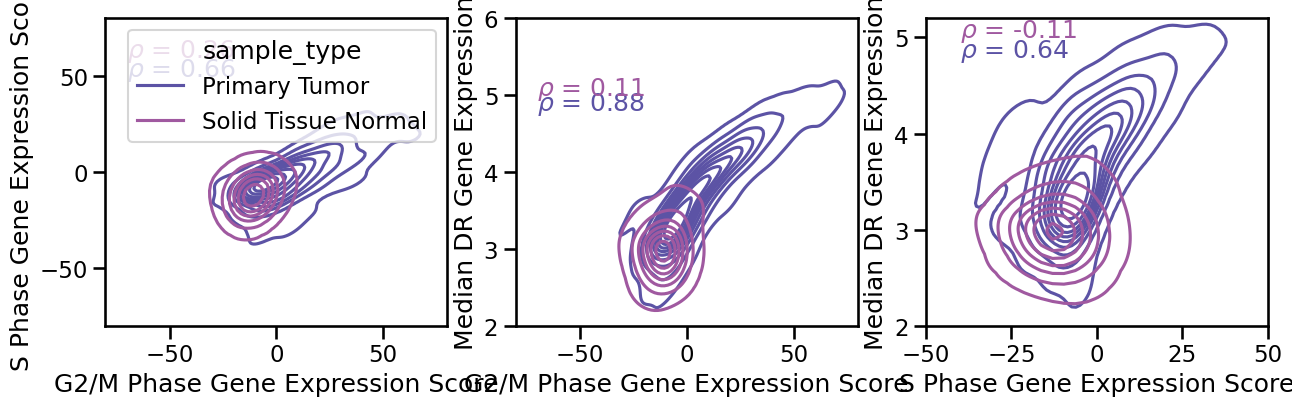

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.set_context('talk')
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score',
    y = 'S_score',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7], 
    ax = axes[0],
    legend = True
    )
# change legend title
axes[0].set_xlim(-80, 80)
axes[0].set_ylim(-80, 80)
axes[0].set_xlabel('G2/M Phase Gene Expression Score')
axes[0].set_ylabel('S Phase Gene Expression Score')
# add the correlation between the two scores for each sample type, use symbol for rho
axes[0].text(-70, 50, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score'),'S_score']), color=my_categorical_palette[5])
axes[0].text(-70, 60, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score'), 'S_score']), color=my_categorical_palette[6])

sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[1]
    )
axes[1].set_xlim(-80, 80)
axes[1].set_ylim(2,6)
axes[1].set_xlabel('G2/M Phase Gene Expression Score')
axes[1].set_ylabel('Median DR Gene Expression')
axes[1].get_legend().remove()
# add the correlation between the two scores for each sample type
axes[1].text(-70, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score'),'median_dream_reg_expr']), color=my_categorical_palette[5])
axes[1].text(-70, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score'), 'median_dream_reg_expr']), color=my_categorical_palette[6])
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'S_score',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[2]
    )

axes[2].set_xlim(-50,50)
axes[2].set_ylim(2,5.2)
axes[2].set_xlabel('S Phase Gene Expression Score')
axes[2].set_ylabel('Median DR Gene Expression')
# remove legend
axes[2].get_legend().remove()
# add the correlation between the two scores for each sample type
axes[2].text(-40, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'S_score'),'median_dream_reg_expr']), color=my_categorical_palette[5])
axes[2].text(-40, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'S_score'), 'median_dream_reg_expr']), color=my_categorical_palette[6])

##### W/out DREAM reg genes

In [ ]:
# deconvolutuion was done in /cellar/users/zkoch/dream/notebooks/010824_cellCycle_deconv.ipynb
cell_cycle_scores = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores_no_DREAM_reg_genes.parquet')
# add _no_dream to the column names
cell_cycle_scores.columns = [col + '_no_dream' for col in cell_cycle_scores.columns]
# merge with dream expression
cptac_expr.dream_expression = cptac_expr.dream_expression.merge(cell_cycle_scores, left_index=True, right_index=True)

In [27]:
corr_by_sample_type = cptac_expr.dream_expression.groupby('sample_type')[['mean_dream_reg_expr', 'median_dream_reg_expr', 'S_score_no_dream', 'G2M_score_no_dream']].corr(method='spearman')
corr_by_sample_type

mean_dream_reg_expr  \
sample_type                                                      
Primary Tumor       mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.988387   
                    S_score_no_dream                  0.852437   
                    G2M_score_no_dream                0.868450   
Solid Tissue Normal mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.938112   
                    S_score_no_dream                  0.725175   
                    G2M_score_no_dream                0.598188   

                                           median_dream_reg_expr  \
sample_type                                                        
Primary Tumor       mean_dream_reg_expr                 0.988387   
                    median_dream_reg_expr               1.000000   
                    S_score_no_dream                    0.839715   
                    G2M_score_no_dream                  0.860955   
Solid Tissue Normal mean_dream_reg_expr                 0.938112   
                    median_dream_reg_expr               1.000000   
                    S_score_no_dream                    0.603150   
                    G2M_score_no_dream                  0.405972   

                                           S_score_no_dream  \
sample_type                                                   
Primary Tumor       mean_dream_reg_expr            0.852437   
                    median_dream_reg_expr          0.839715   
                    S_score_no_dream               1.000000   
                    G2M_score_no_dream             0.865589   
Solid Tissue Normal mean_dream_reg_expr            0.725175   
                    median_dream_reg_expr          0.603150   
                    S_score_no_dream               1.000000   
                    G2M_score_no_dream             0.809851   

                                           G2M_score_no_dream  
sample_type                                                    
Primary Tumor       mean_dream_reg_expr              0.868450  
                    median_dream_reg_expr            0.860955  
                    S_score_no_dream                 0.865589  
                    G2M_score_no_dream               1.000000  
Solid Tissue Normal mean_dream_reg_expr              0.598188  
                    median_dream_reg_expr            0.405972  
                    S_score_no_dream                 0.809851  
                    G2M_score_no_dream               1.000000

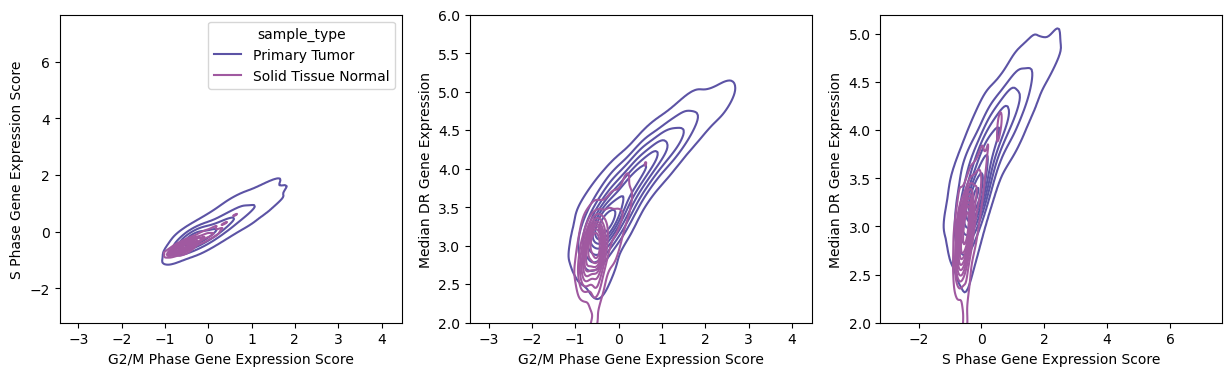

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score_no_dream',
    y = 'S_score_no_dream',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7], 
    ax = axes[0],
    legend = True
    )
#axes[0].set_xlim(-80, 80)
#axes[0].set_ylim(-80, 80)
axes[0].set_xlabel('G2/M Phase Gene Expression Score')
axes[0].set_ylabel('S Phase Gene Expression Score')
# add the correlation between the two scores for each sample type, use symbol for rho
#axes[0].text(-70, 50, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score_no_dream'),'S_score_no_dream']), color=my_categorical_palette[5])
#axes[0].text(-70, 60, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score_no_dream'), 'S_score_no_dream']), color=my_categorical_palette[6])

sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score_no_dream',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[1]
    )
#axes[1].set_xlim(-80, 80)
axes[1].set_ylim(2,6)
axes[1].set_xlabel('G2/M Phase Gene Expression Score')
axes[1].set_ylabel('Median DR Gene Expression')
axes[1].get_legend().remove()
# add the correlation between the two scores for each sample type
#axes[1].text(-70, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score_no_dream'),'median_dream_reg_expr']), color=my_categorical_palette[5])
#axes[1].text(-70, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score_no_dream'), 'median_dream_reg_expr']), color=my_categorical_palette[6])
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'S_score_no_dream',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[2]
    )

#axes[2].set_xlim(-50,50)
axes[2].set_ylim(2,5.2)
axes[2].set_xlabel('S Phase Gene Expression Score')
axes[2].set_ylabel('Median DR Gene Expression')
# remove legend
axes[2].get_legend().remove()
# add the correlation between the two scores for each sample type
#axes[2].text(-40, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'S_score_no_dream'),'median_dream_reg_expr']), color=my_categorical_palette[5])
#axes[2].text(-40, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'S_score_no_dream'), 'median_dream_reg_expr']), color=my_categorical_palette[6])

# Compare with phosphoproteomics

In [34]:
# read in phospho data
kidney_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc_transpose.parquet",
    sep = "\t", index_col=0
    )
kidney_phospho_df.set_index('sample_id', inplace=True, drop=True)

# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(kidney_phospho_df.index)))
kidney_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mean_overall_expr', 'sample_type', 'cancer_type']],
     kidney_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )

# read in phospho data
uterus_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_uterus_ucec_transpose.parquet",
    sep = "\t", index_col=0
    )
uterus_phospho_df.set_index('sample_id', inplace=True, drop=True)
# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(uterus_phospho_df.index)))
uterus_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mean_overall_expr', 'sample_type', 'cancer_type']],
     uterus_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )

phospho_dream_df = pd.concat([kidney_phospho_dream_df, uterus_phospho_dream_df])

In [6]:
# find which lin52 protein to use
# from https://proteomic.datacommons.cancer.gov/pdc/browse and searching the gene
possible_lin52_prot_names = 'G3V5T8;NP_001019845.1;Q52LA3;XP_011535622.1;XP_011535623.1;XP_011535624.2;XP_016877252.1;XP_016877253.1'

"""for prot in possible_lin52_prot_names.split(';'):
    print(prot)
    print(phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(prot)])
    print()"""
lin52_protein = 'NP_001019845.1'
lin52_modifs = phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(lin52_protein)].values

lin52_modifs

array(['NP_001019845.1:s28', 'NP_001019845.1:s53', 'NP_001019845.1:t51'],
      dtype=object)

In [7]:
possible_rbl1_prot_names = 'E9PNB6;H0YE05;NP_001310210.1;NP_001310211.1;NP_002886.2;NP_899662.1;P28749;P28749-2;XP_006723905.1;XP_011527257.1;XP_011527260.1;XP_016883481.1'
"""for prot in possible_rbl1_prot_names.split(';'):
    print(prot)
    print(phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(prot)])
    print()"""
rbl1_protein = 'NP_002886.2'
rbl1_modifs = phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(rbl1_protein)].values
rbl1_modifs

array(['NP_002886.2:s649', 'NP_002886.2:t385', 'NP_002886.2:s1041',
       'NP_002886.2:s640', 'NP_002886.2:s762', 'NP_002886.2:s964',
       'NP_002886.2:s975', 'NP_002886.2:s988', 'NP_002886.2:t332'],
      dtype=object)

### Comparing directly with mutations

In [36]:
# combine dream expression and mutation burden
dream_phospho_v_mut_burden = phospho_dream_df.merge(
     cptac_mut.mutation_burden, left_index=True, right_index=True, how='left'
    )

In [43]:
dream_phospho_v_mut_burden[['sample_type', 'cancer_type_x']].value_counts()

sample_type          cancer_type_x              
Primary Tumor        Endometrioid adenocarcinoma    127
                     Renal cell carcinoma           101
Solid Tissue Normal  Renal cell carcinoma            75
Name: count, dtype: int64

In [22]:
dream_phospho_v_mut_burden[['mutation_burden'] +  lin52_modifs.tolist() + rbl1_modifs.tolist()].corr(method='spearman')

mutation_burden  NP_001019845.1:s28  NP_001019845.1:s53  \
mutation_burden            1.000000            0.310926           -1.000000   
NP_001019845.1:s28         0.310926            1.000000            0.892857   
NP_001019845.1:s53        -1.000000            0.892857            1.000000   
NP_001019845.1:t51         0.800000            0.484636            1.000000   
NP_002886.2:s649          -0.866025            0.383333                 NaN   
NP_002886.2:t385           0.146535            0.533887            0.071429   
NP_002886.2:s1041          0.027273           -0.225799                 NaN   
NP_002886.2:s640           0.150198            0.393980                 NaN   
NP_002886.2:s762          -0.142857            0.500000                 NaN   
NP_002886.2:s964          -0.500000            0.821429                 NaN   
NP_002886.2:s975          -0.260606            0.429666                 NaN   
NP_002886.2:s988          -0.392857            0.607143                 NaN   
NP_002886.2:t332          -0.107462            0.383816                 NaN   

                    NP_001019845.1:t51  NP_002886.2:s649  NP_002886.2:t385  \
mutation_burden               0.800000         -0.866025          0.146535   
NP_001019845.1:s28            0.484636          0.383333          0.533887   
NP_001019845.1:s53            1.000000               NaN          0.071429   
NP_001019845.1:t51            1.000000               NaN          0.071429   
NP_002886.2:s649                   NaN          1.000000               NaN   
NP_002886.2:t385              0.071429               NaN          1.000000   
NP_002886.2:s1041                  NaN               NaN          0.560674   
NP_002886.2:s640                   NaN               NaN          0.064233   
NP_002886.2:s762                   NaN               NaN          0.555882   
NP_002886.2:s964                   NaN               NaN          0.964286   
NP_002886.2:s975                   NaN               NaN          0.178571   
NP_002886.2:s988                   NaN               NaN          0.214477   
NP_002886.2:t332                   NaN               NaN          0.376316   

                    NP_002886.2:s1041  NP_002886.2:s640  NP_002886.2:s762  \
mutation_burden              0.027273          0.150198         -0.142857   
NP_001019845.1:s28          -0.225799          0.393980          0.500000   
NP_001019845.1:s53                NaN               NaN               NaN   
NP_001019845.1:t51                NaN               NaN               NaN   
NP_002886.2:s649                  NaN               NaN               NaN   
NP_002886.2:t385             0.560674          0.064233          0.555882   
NP_002886.2:s1041            1.000000          0.678571               NaN   
NP_002886.2:s640             0.678571          1.000000               NaN   
NP_002886.2:s762                  NaN               NaN          1.000000   
NP_002886.2:s964                  NaN          0.857143               NaN   
NP_002886.2:s975                  NaN               NaN          0.750000   
NP_002886.2:s988                  NaN          0.535714          0.619048   
NP_002886.2:t332             0.207143          0.429902          0.928571   

                    NP_002886.2:s964  NP_002886.2:s975  NP_002886.2:s988  \
mutation_burden            -0.500000         -0.260606         -0.392857   
NP_001019845.1:s28          0.821429          0.429666          0.607143   
NP_001019845.1:s53               NaN               NaN               NaN   
NP_001019845.1:t51               NaN               NaN               NaN   
NP_002886.2:s649                 NaN               NaN               NaN   
NP_002886.2:t385            0.964286          0.178571          0.214477   
NP_002886.2:s1041                NaN               NaN               NaN   
NP_002886.2:s640            0.857143               NaN          0.535714   
NP_002886.2:s762                 NaN          0.750000   

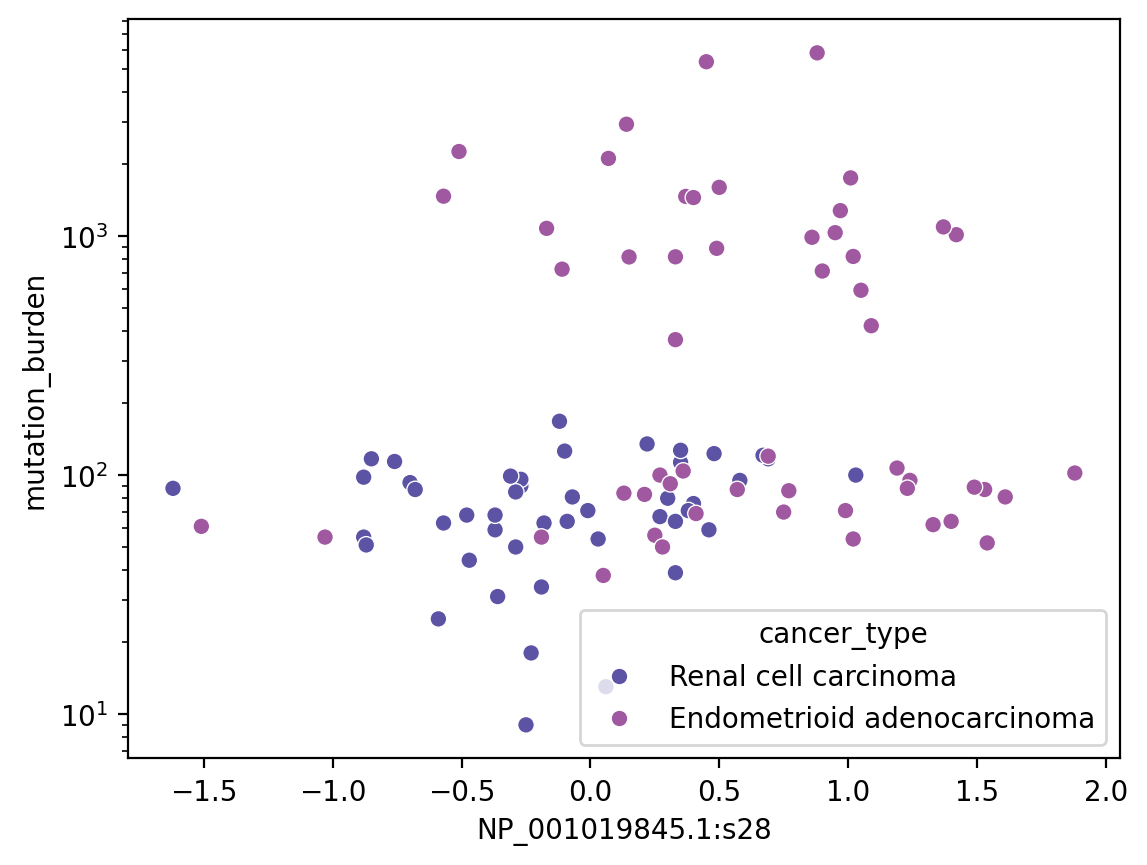

In [31]:
sns.scatterplot(
    data = dream_phospho_v_mut_burden,
    y = 'mutation_burden',
    x = lin52_modifs[0],
    hue = 'cancer_type',
    
    palette=my_categorical_palette[5:7]
    )
plt.yscale('log')

In [28]:
lin52_col = lin52_modifs[0]
# get non-na value for pearsonr
dream_non_nan = dream_phospho_v_mut_burden[(~dream_phospho_v_mut_burden['mutation_burden'].isna())]
lin52_non_nan = dream_phospho_v_mut_burden[(~dream_phospho_v_mut_burden[lin52_col].isna())]
shared_samples = list(set(dream_non_nan.index).intersection(set(lin52_non_nan.index)))

pearsonr(dream_non_nan.loc[shared_samples, 'mutation_burden'], lin52_non_nan.loc[shared_samples, lin52_col])

PearsonRResult(statistic=0.13241241620921868, pvalue=0.1913772551063217)

##### Comparing with DREAM expr signature

In [116]:
# only s28 is trustworthy
(~phospho_dream_df[lin52_modifs].isna()).sum()

NP_001019845.1:s28    295
NP_001019845.1:s53      7
NP_001019845.1:t51     19
dtype: int64

In [102]:
# rbl1
(~phospho_dream_df[rbl1_modifs].isna()).sum()

NP_002886.2:s1041    24
NP_002886.2:s640     46
NP_002886.2:s762     16
NP_002886.2:s964      7
NP_002886.2:s975     23
NP_002886.2:s988     15
NP_002886.2:t332     79
NP_002886.2:t385     81
dtype: int64

In [47]:
phospho_dream_df.groupby(['sample_type', 'cancer_type'])[lin52_modifs.tolist() + ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mean_overall_expr']].corr(method='spearman')

NP_001019845.1:s28  \
sample_type         cancer_type                                                                 
Primary Tumor       Endometrioid adenocarcinoma NP_001019845.1:s28                   1.000000   
                                                NP_001019845.1:s53                        NaN   
                                                NP_001019845.1:t51                        NaN   
                                                mean_dream_reg_expr                  0.210840   
                                                mean_dream_reg_expr_resid            0.188890   
                                                mean_overall_expr                    0.332770   
                    Renal cell carcinoma        NP_001019845.1:s28                   1.000000   
                                                NP_001019845.1:s53                   1.000000   
                                                NP_001019845.1:t51                   0.738095   
                                                mean_dream_reg_expr                  0.195612   
                                                mean_dream_reg_expr_resid            0.215520   
                                                mean_overall_expr                    0.067868   
Solid Tissue Normal Renal cell carcinoma        NP_001019845.1:s28                   1.000000   
                                                NP_001019845.1:s53                   0.400000   
                                                NP_001019845.1:t51                   0.054545   
                                                mean_dream_reg_expr                  0.496340   
                                                mean_dream_reg_expr_resid            0.393657   
                                                mean_overall_expr                    0.410218   

                                                                           NP_001019845.1:s53  \
sample_type         cancer_type                                                                 
Primary Tumor       Endometrioid adenocarcinoma NP_001019845.1:s28                        NaN   
                                                NP_001019845.1:s53                        NaN   
                                                NP_001019845.1:t51                        NaN   
                                                mean_dream_reg_expr                       NaN   
                                                mean_dream_reg_expr_resid                 NaN   
                                                mean_overall_expr                         NaN   
                    Renal cell carcinoma        NP_001019845.1:s28                        1.0   
                                                NP_001019845.1:s53                        1.0   
                                                NP_001019845.1:t51                        1.0   
                                                mean_dream_reg_expr                       0.5   
                                                mean_dream_reg_expr_resid                 0.5   
                                                mean_overall_expr                        -0.5   
Solid Tissue Normal Renal cell carcinoma        NP_001019845.1:s28                        0.4   
                                                NP_001019845.1:s53                        1.0   
                                                NP_001019845.1:t51                        1.0   
                                                mean_dream_reg_expr                      -0.2   
                                                mean_dream_reg_expr_resid                -0.8   
                                                mean_overall_expr                         1.0   

                                                                           NP_001019845.1:t51  \
sample_type         cancer_type                                                                 

In [123]:
phospho_dream_df[rbl1_modifs.tolist() + ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid','mean_overall_expr']].corr(method='pearson')

NP_002886.2:s1041  NP_002886.2:s640  \
NP_002886.2:s1041                   1.000000          0.702464   
NP_002886.2:s640                    0.702464          1.000000   
NP_002886.2:s762                         NaN               NaN   
NP_002886.2:s964                         NaN          0.819910   
NP_002886.2:s975                         NaN               NaN   
NP_002886.2:s988                         NaN          0.679518   
NP_002886.2:t332                    0.330797          0.420474   
NP_002886.2:t385                    0.507680         -0.039521   
mean_dream_reg_expr                 0.007062          0.250650   
mean_dream_reg_expr_resid           0.074453          0.236311   
mean_overall_expr                  -0.090604          0.139889   

                           NP_002886.2:s762  NP_002886.2:s964  \
NP_002886.2:s1041                       NaN               NaN   
NP_002886.2:s640                        NaN          0.819910   
NP_002886.2:s762                   1.000000               NaN   
NP_002886.2:s964                        NaN          1.000000   
NP_002886.2:s975                   0.543726               NaN   
NP_002886.2:s988                   0.684459          0.715714   
NP_002886.2:t332                   0.899067          0.860425   
NP_002886.2:t385                   0.587509          0.801467   
mean_dream_reg_expr                0.479700          0.735003   
mean_dream_reg_expr_resid          0.427890          0.705825   
mean_overall_expr                  0.521294          0.710649   

                           NP_002886.2:s975  NP_002886.2:s988  \
NP_002886.2:s1041                       NaN               NaN   
NP_002886.2:s640                        NaN          0.679518   
NP_002886.2:s762                   0.543726          0.684459   
NP_002886.2:s964                        NaN          0.715714   
NP_002886.2:s975                   1.000000               NaN   
NP_002886.2:s988                        NaN          1.000000   
NP_002886.2:t332                        NaN          0.672225   
NP_002886.2:t385                   0.181873          0.529717   
mean_dream_reg_expr                0.479176          0.741457   
mean_dream_reg_expr_resid          0.453355          0.703707   
mean_overall_expr                  0.227397          0.560039   

                           NP_002886.2:t332  NP_002886.2:t385  \
NP_002886.2:s1041                  0.330797          0.507680   
NP_002886.2:s640                   0.420474         -0.039521   
NP_002886.2:s762                   0.899067          0.587509   
NP_002886.2:s964                   0.860425          0.801467   
NP_002886.2:s975                        NaN          0.181873   
NP_002886.2:s988                   0.672225          0.529717   
NP_002886.2:t332                   1.000000          0.292413   
NP_002886.2:t385                   0.292413          1.000000   
mean_dream_reg_expr                0.136329          0.472738   
mean_dream_reg_expr_resid          0.140671          0.468950   
mean_overall_expr                  0.024734         -0.009314   

                           mean_dream_reg_expr  mean_dream_reg_expr_resid  \
NP_002886.2:s1041                     0.007062                   0.074453   
NP_002886.2:s640                      0.250650                   0.236311   
NP_002886.2:s762                      0.479700                   0.427890   
NP_002886.2:s964                      0.735003                   0.705825   
NP_002886.2:s975                      0.479176                   0.453355   
NP_002886.2:s988                      0.741457                   0.703707   
NP_002886.2:t332                      0.136329                   0.140671   
NP_002886.2:t385                      0.472738                   0.468950   
mean_dream_reg_expr                   1.000000                   0.995768   
mean_dream_reg_expr_resid             0.995768                   1.000000   
mean_overall_expr                    -0.0133

In [133]:
# DREAM = only upregulated in dryk1a inhibs
phospho_dream_df[rbl1_modifs.tolist() + ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid','mean_overall_expr']].corr(method='pearson')

NP_002886.2:s1041  NP_002886.2:s640  \
NP_002886.2:s1041                   1.000000          0.702464   
NP_002886.2:s640                    0.702464          1.000000   
NP_002886.2:s762                         NaN               NaN   
NP_002886.2:s964                         NaN          0.819910   
NP_002886.2:s975                         NaN               NaN   
NP_002886.2:s988                         NaN          0.679518   
NP_002886.2:t332                    0.330797          0.420474   
NP_002886.2:t385                    0.507680         -0.039521   
mean_dream_reg_expr                 0.080398          0.252532   
mean_dream_reg_expr_resid           0.120800          0.259073   
mean_overall_expr                  -0.090604          0.139889   

                           NP_002886.2:s762  NP_002886.2:s964  \
NP_002886.2:s1041                       NaN               NaN   
NP_002886.2:s640                        NaN          0.819910   
NP_002886.2:s762                   1.000000               NaN   
NP_002886.2:s964                        NaN          1.000000   
NP_002886.2:s975                   0.543726               NaN   
NP_002886.2:s988                   0.684459          0.715714   
NP_002886.2:t332                   0.899067          0.860425   
NP_002886.2:t385                   0.587509          0.801467   
mean_dream_reg_expr                0.508755          0.761911   
mean_dream_reg_expr_resid          0.505772          0.759358   
mean_overall_expr                  0.521294          0.710649   

                           NP_002886.2:s975  NP_002886.2:s988  \
NP_002886.2:s1041                       NaN               NaN   
NP_002886.2:s640                        NaN          0.679518   
NP_002886.2:s762                   0.543726          0.684459   
NP_002886.2:s964                        NaN          0.715714   
NP_002886.2:s975                   1.000000               NaN   
NP_002886.2:s988                        NaN          1.000000   
NP_002886.2:t332                        NaN          0.672225   
NP_002886.2:t385                   0.181873          0.529717   
mean_dream_reg_expr                0.288161          0.733115   
mean_dream_reg_expr_resid          0.299015          0.728361   
mean_overall_expr                  0.227397          0.560039   

                           NP_002886.2:t332  NP_002886.2:t385  \
NP_002886.2:s1041                  0.330797          0.507680   
NP_002886.2:s640                   0.420474         -0.039521   
NP_002886.2:s762                   0.899067          0.587509   
NP_002886.2:s964                   0.860425          0.801467   
NP_002886.2:s975                        NaN          0.181873   
NP_002886.2:s988                   0.672225          0.529717   
NP_002886.2:t332                   1.000000          0.292413   
NP_002886.2:t385                   0.292413          1.000000   
mean_dream_reg_expr                0.183401          0.434023   
mean_dream_reg_expr_resid          0.186291          0.433454   
mean_overall_expr                  0.024734         -0.009314   

                           mean_dream_reg_expr  mean_dream_reg_expr_resid  \
NP_002886.2:s1041                     0.080398                   0.120800   
NP_002886.2:s640                      0.252532                   0.259073   
NP_002886.2:s762                      0.508755                   0.505772   
NP_002886.2:s964                      0.761911                   0.759358   
NP_002886.2:s975                      0.288161                   0.299015   
NP_002886.2:s988                      0.733115                   0.728361   
NP_002886.2:t332                      0.183401                   0.186291   
NP_002886.2:t385                      0.434023                   0.433454   
mean_dream_reg_expr                   1.000000                   0.999420   
mean_dream_reg_expr_resid             0.999420                   1.000000   
mean_overall_expr                    -0.0589

In [83]:
rbl1_col = rbl1_modifs[1]
# get non-na value for pearsonr
dream_non_nan = phospho_dream_df[(~phospho_dream_df['mean_dream_reg_expr'].isna())]
rbl1_non_nan = phospho_dream_df[(~phospho_dream_df[rbl1_col].isna())]
shared_samples = list(set(dream_non_nan.index).intersection(set(rbl1_non_nan.index)))

pearsonr(dream_non_nan.loc[shared_samples, 'mean_dream_reg_expr'], rbl1_non_nan.loc[shared_samples, rbl1_col])

PearsonRResult(statistic=0.2506495171317416, pvalue=0.09292961700106259)

In [136]:
lin52_col = lin52_modifs[0]
# get non-na value for pearsonr
dream_non_nan = phospho_dream_df[(~phospho_dream_df['mean_dream_reg_expr'].isna())]
lin52_non_nan = phospho_dream_df[(~phospho_dream_df[lin52_col].isna())]
shared_samples = list(set(dream_non_nan.index).intersection(set(lin52_non_nan.index)))

pearsonr(dream_non_nan.loc[shared_samples, 'mean_dream_reg_expr'], lin52_non_nan.loc[shared_samples, lin52_col])

PearsonRResult(statistic=0.324726376403516, pvalue=1.1355069590328191e-08)

<Axes: xlabel='mean_dream_reg_expr', ylabel='NP_001019845.1:s28'>

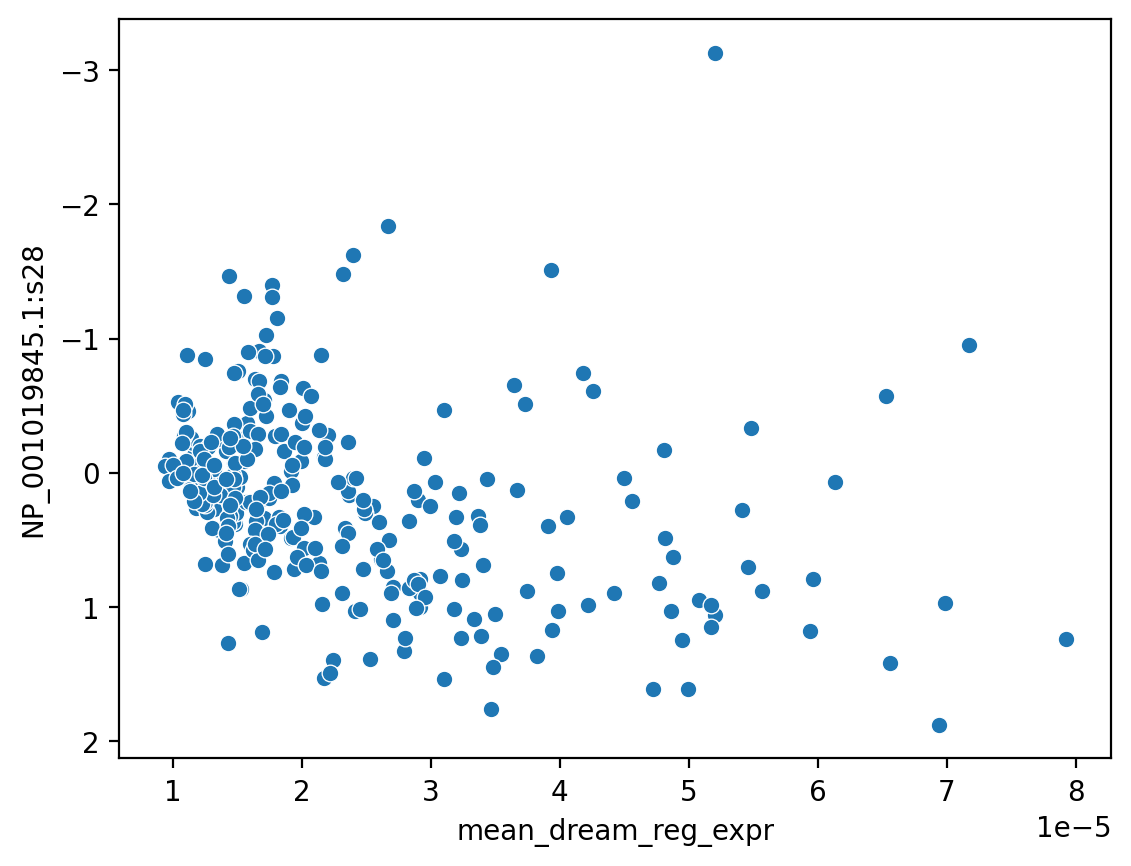

In [137]:
sns.scatterplot(
    data = phospho_dream_df,
    x = 'mean_dream_reg_expr',
    y = lin52_modifs[0],
    #hue = 'sample_type',
    #palette=my_categorical_palette[5:7]
    )

### Get mutation burdens

/tmp/ipykernel_1457142/644110067.py:1: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.scatterplot(


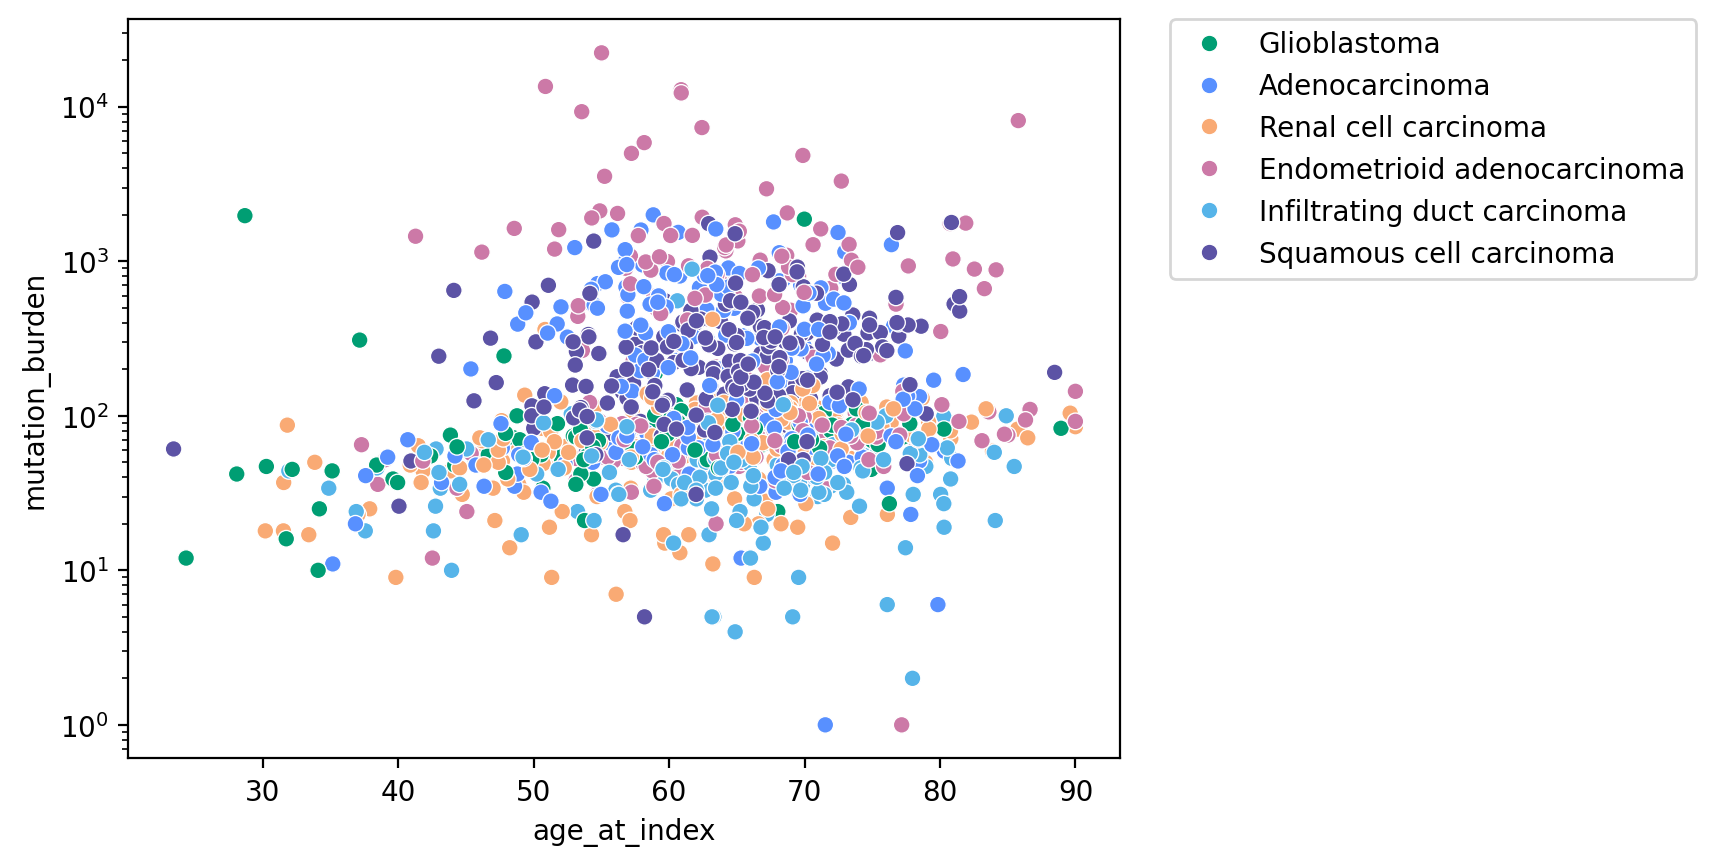

In [10]:
sns.scatterplot(
    data = cptac_mut.mutation_burden.query("num_samples_this_case == 1"),
    x = 'age_at_index', y = 'mutation_burden', hue = 'cancer_type', 
    palette=my_categorical_palette, 
)
plt.yscale('log')
# move legend onto plot
_ =plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Compare dream expression to mutation burden across tissue

<Axes: xlabel='tissue', ylabel='normalized_value'>

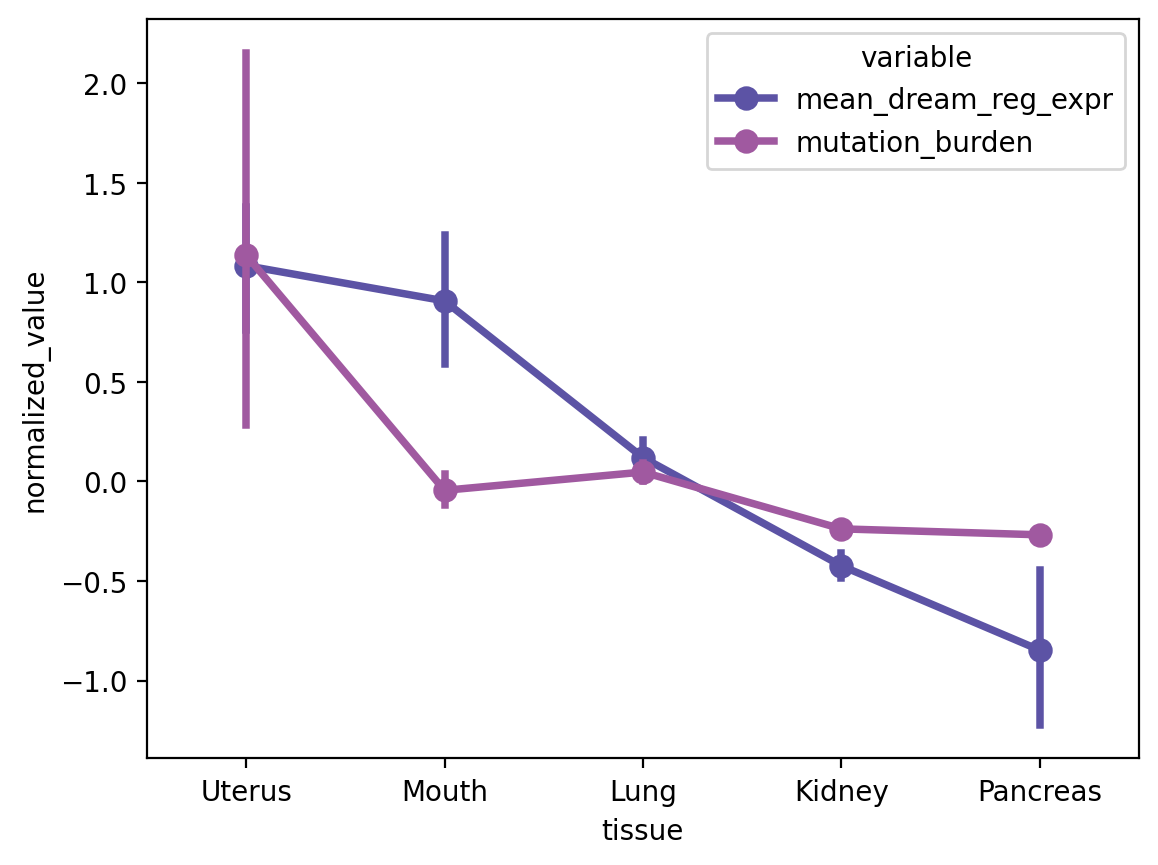

In [11]:
# combine dream expression and mutation burden, for normal tissue only
# have to join on case_id because there are no sample_ids with mutation for normal tissue
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
normal_expr_v_burden = normal_tissue_dream_expr.merge(
    cptac_mut.mutation_burden[['case_id', 'mutation_burden']], 
    on='case_id', how = 'left'
    )
# want rows with tissue, mean_dream_reg_expr, and mutation_burden
normal_expr_v_burden_long = normal_expr_v_burden.melt(
    id_vars = ['case_id', 'tissue', 'age_at_index'],
    value_vars = ['mutation_burden', 'mean_dream_reg_expr'],
    var_name = 'variable',
    value_name = 'value'
    )
# normalize within each variable value 
normal_expr_v_burden_long['normalized_value'] = normal_expr_v_burden_long.groupby('variable')['value'].transform(lambda x: (x - x.mean()) / x.std())

# set order based on normalized dream expression
orderr = normal_expr_v_burden.groupby('tissue')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
sns.pointplot(
    data = normal_expr_v_burden_long, hue = 'variable', x = 'tissue', y = 'normalized_value',
    palette=my_categorical_palette[5:7],  order = orderr, 
    hue_order=['mean_dream_reg_expr', 'mutation_burden',]
    )

<Axes: xlabel='tissue', ylabel='normalized_value'>

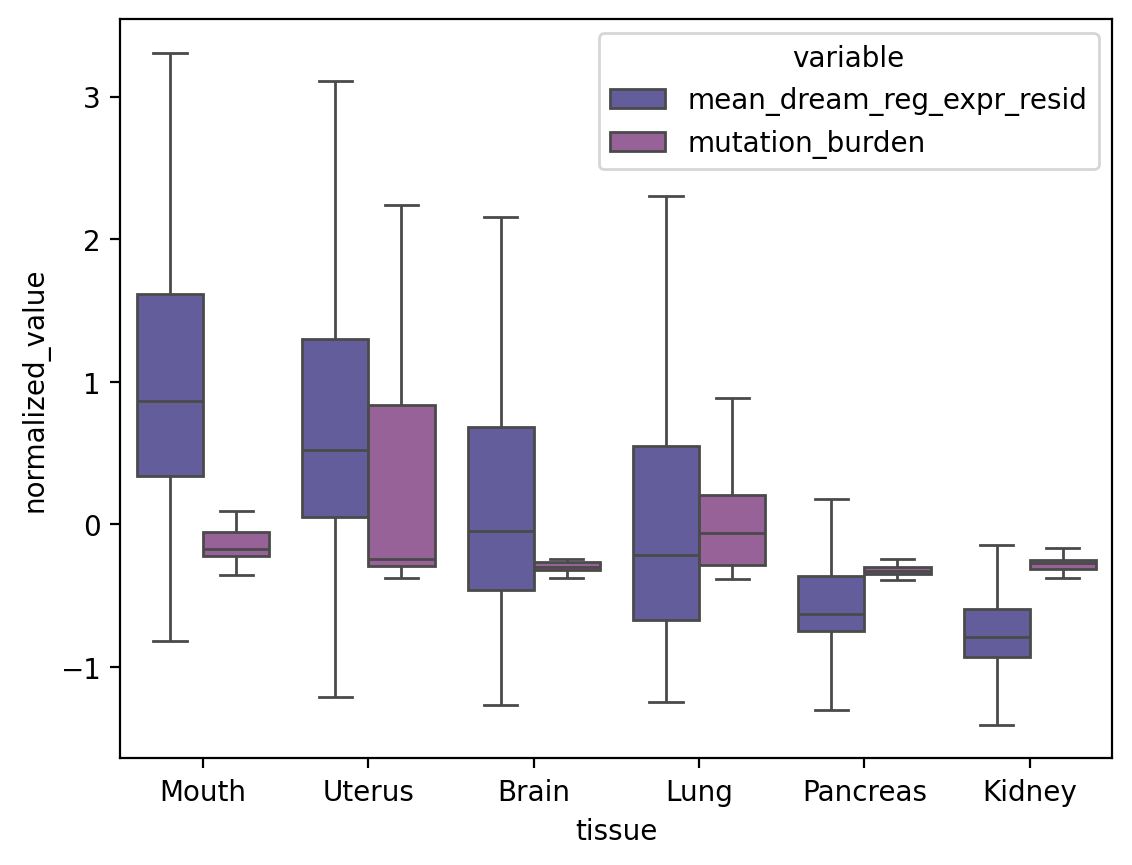

In [13]:
# combine dream expression and mutation burden
dream_exp_v_mut_burden = cptac_expr.dream_expression.merge(
     cptac_mut.mutation_burden, left_index=True, right_index=True, how='left'
    )
# remove _x columns
dream_exp_v_mut_burden = dream_exp_v_mut_burden.loc[:,~dream_exp_v_mut_burden.columns.str.endswith('_x')]
# remive _x from column names
dream_exp_v_mut_burden.columns = dream_exp_v_mut_burden.columns.str.rstrip('_y')
tumor_expr_v_burden = dream_exp_v_mut_burden.dropna(subset=['mutation_burden'])
# want rows with tissue, mean_dream_reg_expr, and mutation_burden
tumor_expr_v_burden_long = tumor_expr_v_burden.melt(
    id_vars = ['case_id', 'tissue', 'age_at_index'],
    value_vars = ['mutation_burden', 'mean_dream_reg_expr_resid'],
    var_name = 'variable',
    value_name = 'value'
    )
# normalize within each variable value 
tumor_expr_v_burden_long['normalized_value'] = tumor_expr_v_burden_long.groupby('variable')['value'].transform(lambda x: (x - x.mean()) / x.std())
# set order based on normalized dream expression
orderr = tumor_expr_v_burden.groupby('tissue')['mean_dream_reg_expr_resid'].median().sort_values(ascending=False).index
sns.boxplot(
    data = tumor_expr_v_burden_long, hue = 'variable', x = 'tissue', y = 'normalized_value',
    palette=my_categorical_palette[5:7],  order = orderr, showfliers=False,
    hue_order=['mean_dream_reg_expr_resid', 'mutation_burden',]
    )


### Compare dream expression to mutation burden within each tissue

In [16]:
normal_expr_v_burden.groupby('tissue')[
    ['mutation_burden', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']
    ].corr(method='spearman')

mutation_burden  mean_dream_reg_expr  \
tissue                                                                     
Kidney   mutation_burden                   1.000000             0.069454   
         mean_dream_reg_expr               0.069454             1.000000   
         mean_dream_reg_expr_resid         0.034389             0.965600   
Lung     mutation_burden                   1.000000            -0.296225   
         mean_dream_reg_expr              -0.296225             1.000000   
         mean_dream_reg_expr_resid        -0.289817             0.974493   
Mouth    mutation_burden                   1.000000            -0.043793   
         mean_dream_reg_expr              -0.043793             1.000000   
         mean_dream_reg_expr_resid        -0.069441             0.989794   
Pancreas mutation_burden                   1.000000             0.320744   
         mean_dream_reg_expr               0.320744             1.000000   
         mean_dream_reg_expr_resid         0.333594             0.986854   
Uterus   mutation_burden                   1.000000             0.286483   
         mean_dream_reg_expr               0.286483             1.000000   
         mean_dream_reg_expr_resid         0.280931             0.984848   

                                    mean_dream_reg_expr_resid  
tissue                                                         
Kidney   mutation_burden                             0.034389  
         mean_dream_reg_expr                         0.965600  
         mean_dream_reg_expr_resid                   1.000000  
Lung     mutation_burden                            -0.289817  
         mean_dream_reg_expr                         0.974493  
         mean_dream_reg_expr_resid                   1.000000  
Mouth    mutation_burden                            -0.069441  
         mean_dream_reg_expr                         0.989794  
         mean_dream_reg_expr_resid                   1.000000  
Pancreas mutation_burden                             0.333594  
         mean_dream_reg_expr                         0.986854  
         mean_dream_reg_expr_resid                   1.000000  
Uterus   mutation_burden                             0.280931  
         mean_dream_reg_expr                         0.984848  
         mean_dream_reg_expr_resid                   1.000000

In [17]:
tumor_expr_v_burden.groupby('tissue')[
    ['mutation_burden', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']
    ].corr(method='spearman')

mutation_burden  mean_dream_reg_expr  \
tissue                                                                     
Brain    mutation_burden                   1.000000             0.463502   
         mean_dream_reg_expr               0.463502             1.000000   
         mean_dream_reg_expr_resid         0.439022             0.990485   
Kidney   mutation_burden                   1.000000             0.110894   
         mean_dream_reg_expr               0.110894             1.000000   
         mean_dream_reg_expr_resid         0.165022             0.757856   
Lung     mutation_burden                   1.000000             0.573455   
         mean_dream_reg_expr               0.573455             1.000000   
         mean_dream_reg_expr_resid         0.551041             0.981585   
Mouth    mutation_burden                   1.000000             0.270635   
         mean_dream_reg_expr               0.270635             1.000000   
         mean_dream_reg_expr_resid         0.284818             0.986932   
Pancreas mutation_burden                   1.000000             0.418975   
         mean_dream_reg_expr               0.418975             1.000000   
         mean_dream_reg_expr_resid         0.405063             0.956282   
Uterus   mutation_burden                   1.000000             0.305751   
         mean_dream_reg_expr               0.305751             1.000000   
         mean_dream_reg_expr_resid         0.349173             0.976464   

                                    mean_dream_reg_expr_resid  
tissue                                                         
Brain    mutation_burden                             0.439022  
         mean_dream_reg_expr                         0.990485  
         mean_dream_reg_expr_resid                   1.000000  
Kidney   mutation_burden                             0.165022  
         mean_dream_reg_expr                         0.757856  
         mean_dream_reg_expr_resid                   1.000000  
Lung     mutation_burden                             0.551041  
         mean_dream_reg_expr                         0.981585  
         mean_dream_reg_expr_resid                   1.000000  
Mouth    mutation_burden                             0.284818  
         mean_dream_reg_expr                         0.986932  
         mean_dream_reg_expr_resid                   1.000000  
Pancreas mutation_burden                             0.405063  
         mean_dream_reg_expr                         0.956282  
         mean_dream_reg_expr_resid                   1.000000  
Uterus   mutation_burden                             0.349173  
         mean_dream_reg_expr                         0.976464  
         mean_dream_reg_expr_resid                   1.000000

/tmp/ipykernel_1144909/3204731905.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


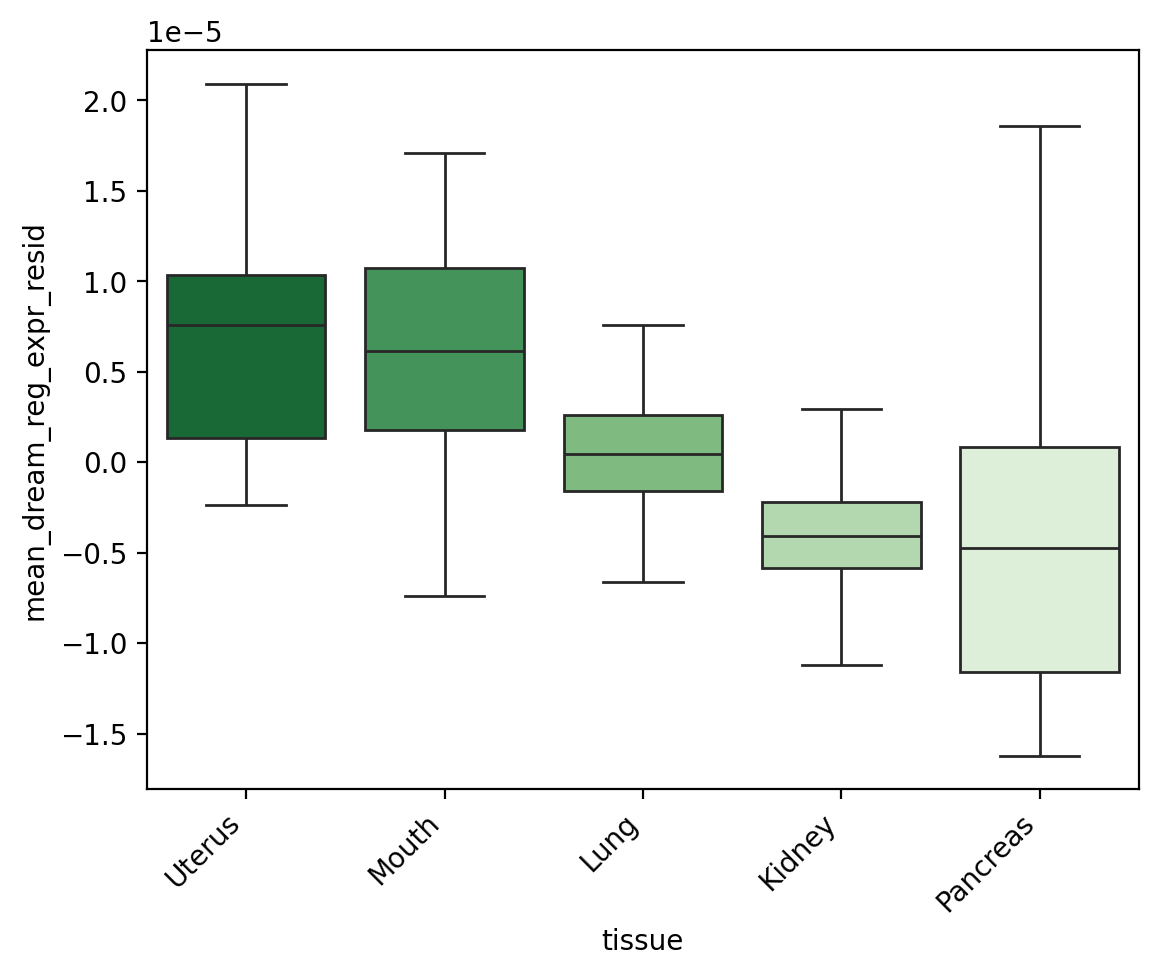

In [75]:
mean_expr_order = normal_expr_v_burden.groupby('tissue')['mean_dream_reg_expr_resid'].median().sort_values(ascending=False).index
sns.boxplot(
    data = normal_expr_v_burden, x = 'tissue', 
    y = 'mean_dream_reg_expr_resid', showfliers=False,
    order=mean_expr_order, palette="Greens_r"
)
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

/tmp/ipykernel_1144909/2069206435.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = normal_expr_v_burden, x = 'tissue', y = 'mutation_burden', showfliers=False, order=burden_order, palette="Greens")


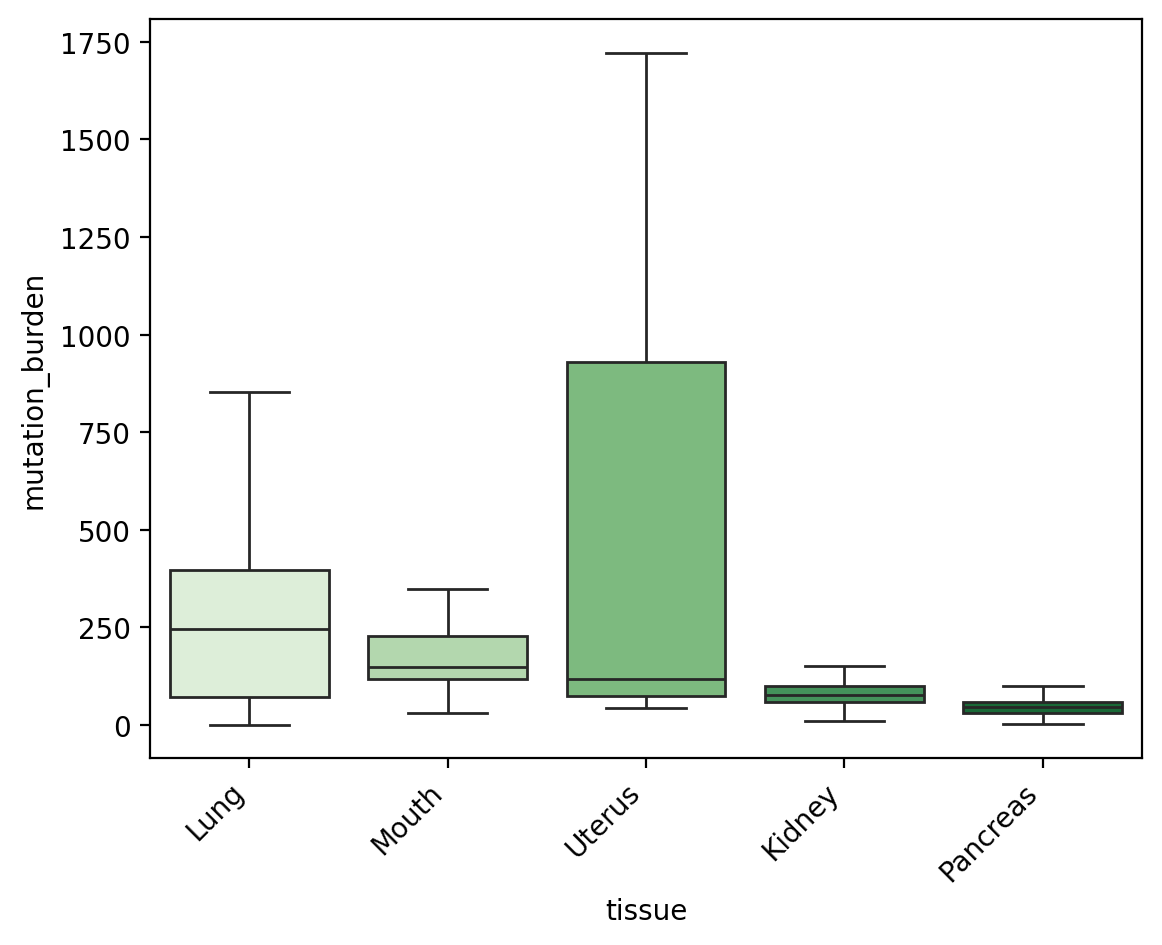

In [76]:
burden_order = normal_expr_v_burden.groupby('tissue')['mutation_burden'].median().sort_values(ascending=False).index
sns.boxplot(data = normal_expr_v_burden, x = 'tissue', y = 'mutation_burden', showfliers=False, order=burden_order, palette="Greens")
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

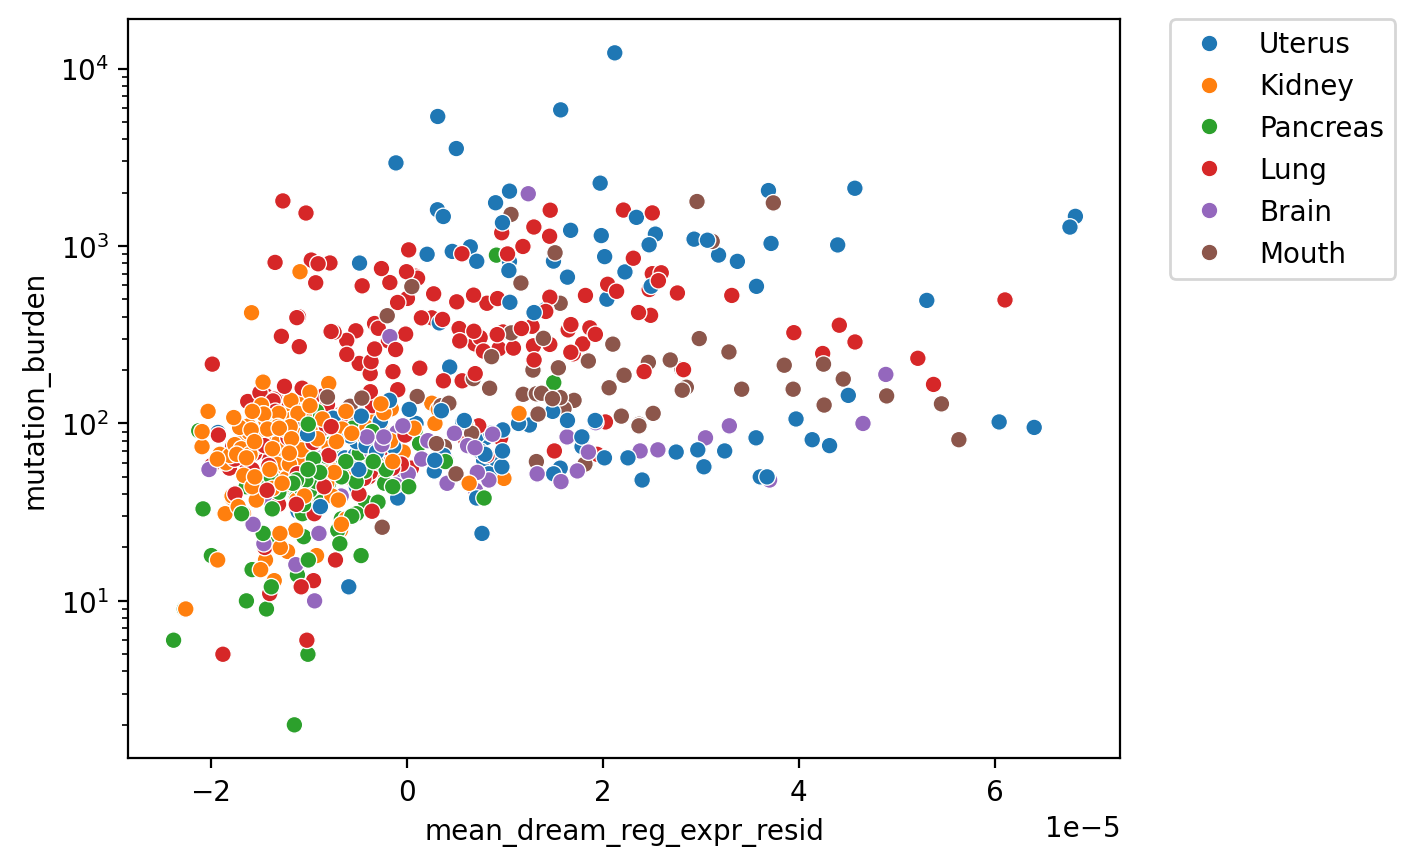

In [78]:
sns.scatterplot(
    data = tumor_expr_v_burden,
    y = 'mutation_burden', x = 'mean_dream_reg_expr_resid', hue = 'tissue',
)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/tmp/ipykernel_1144909/1933460022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr_resid':'DREAM Target Gene activity'
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


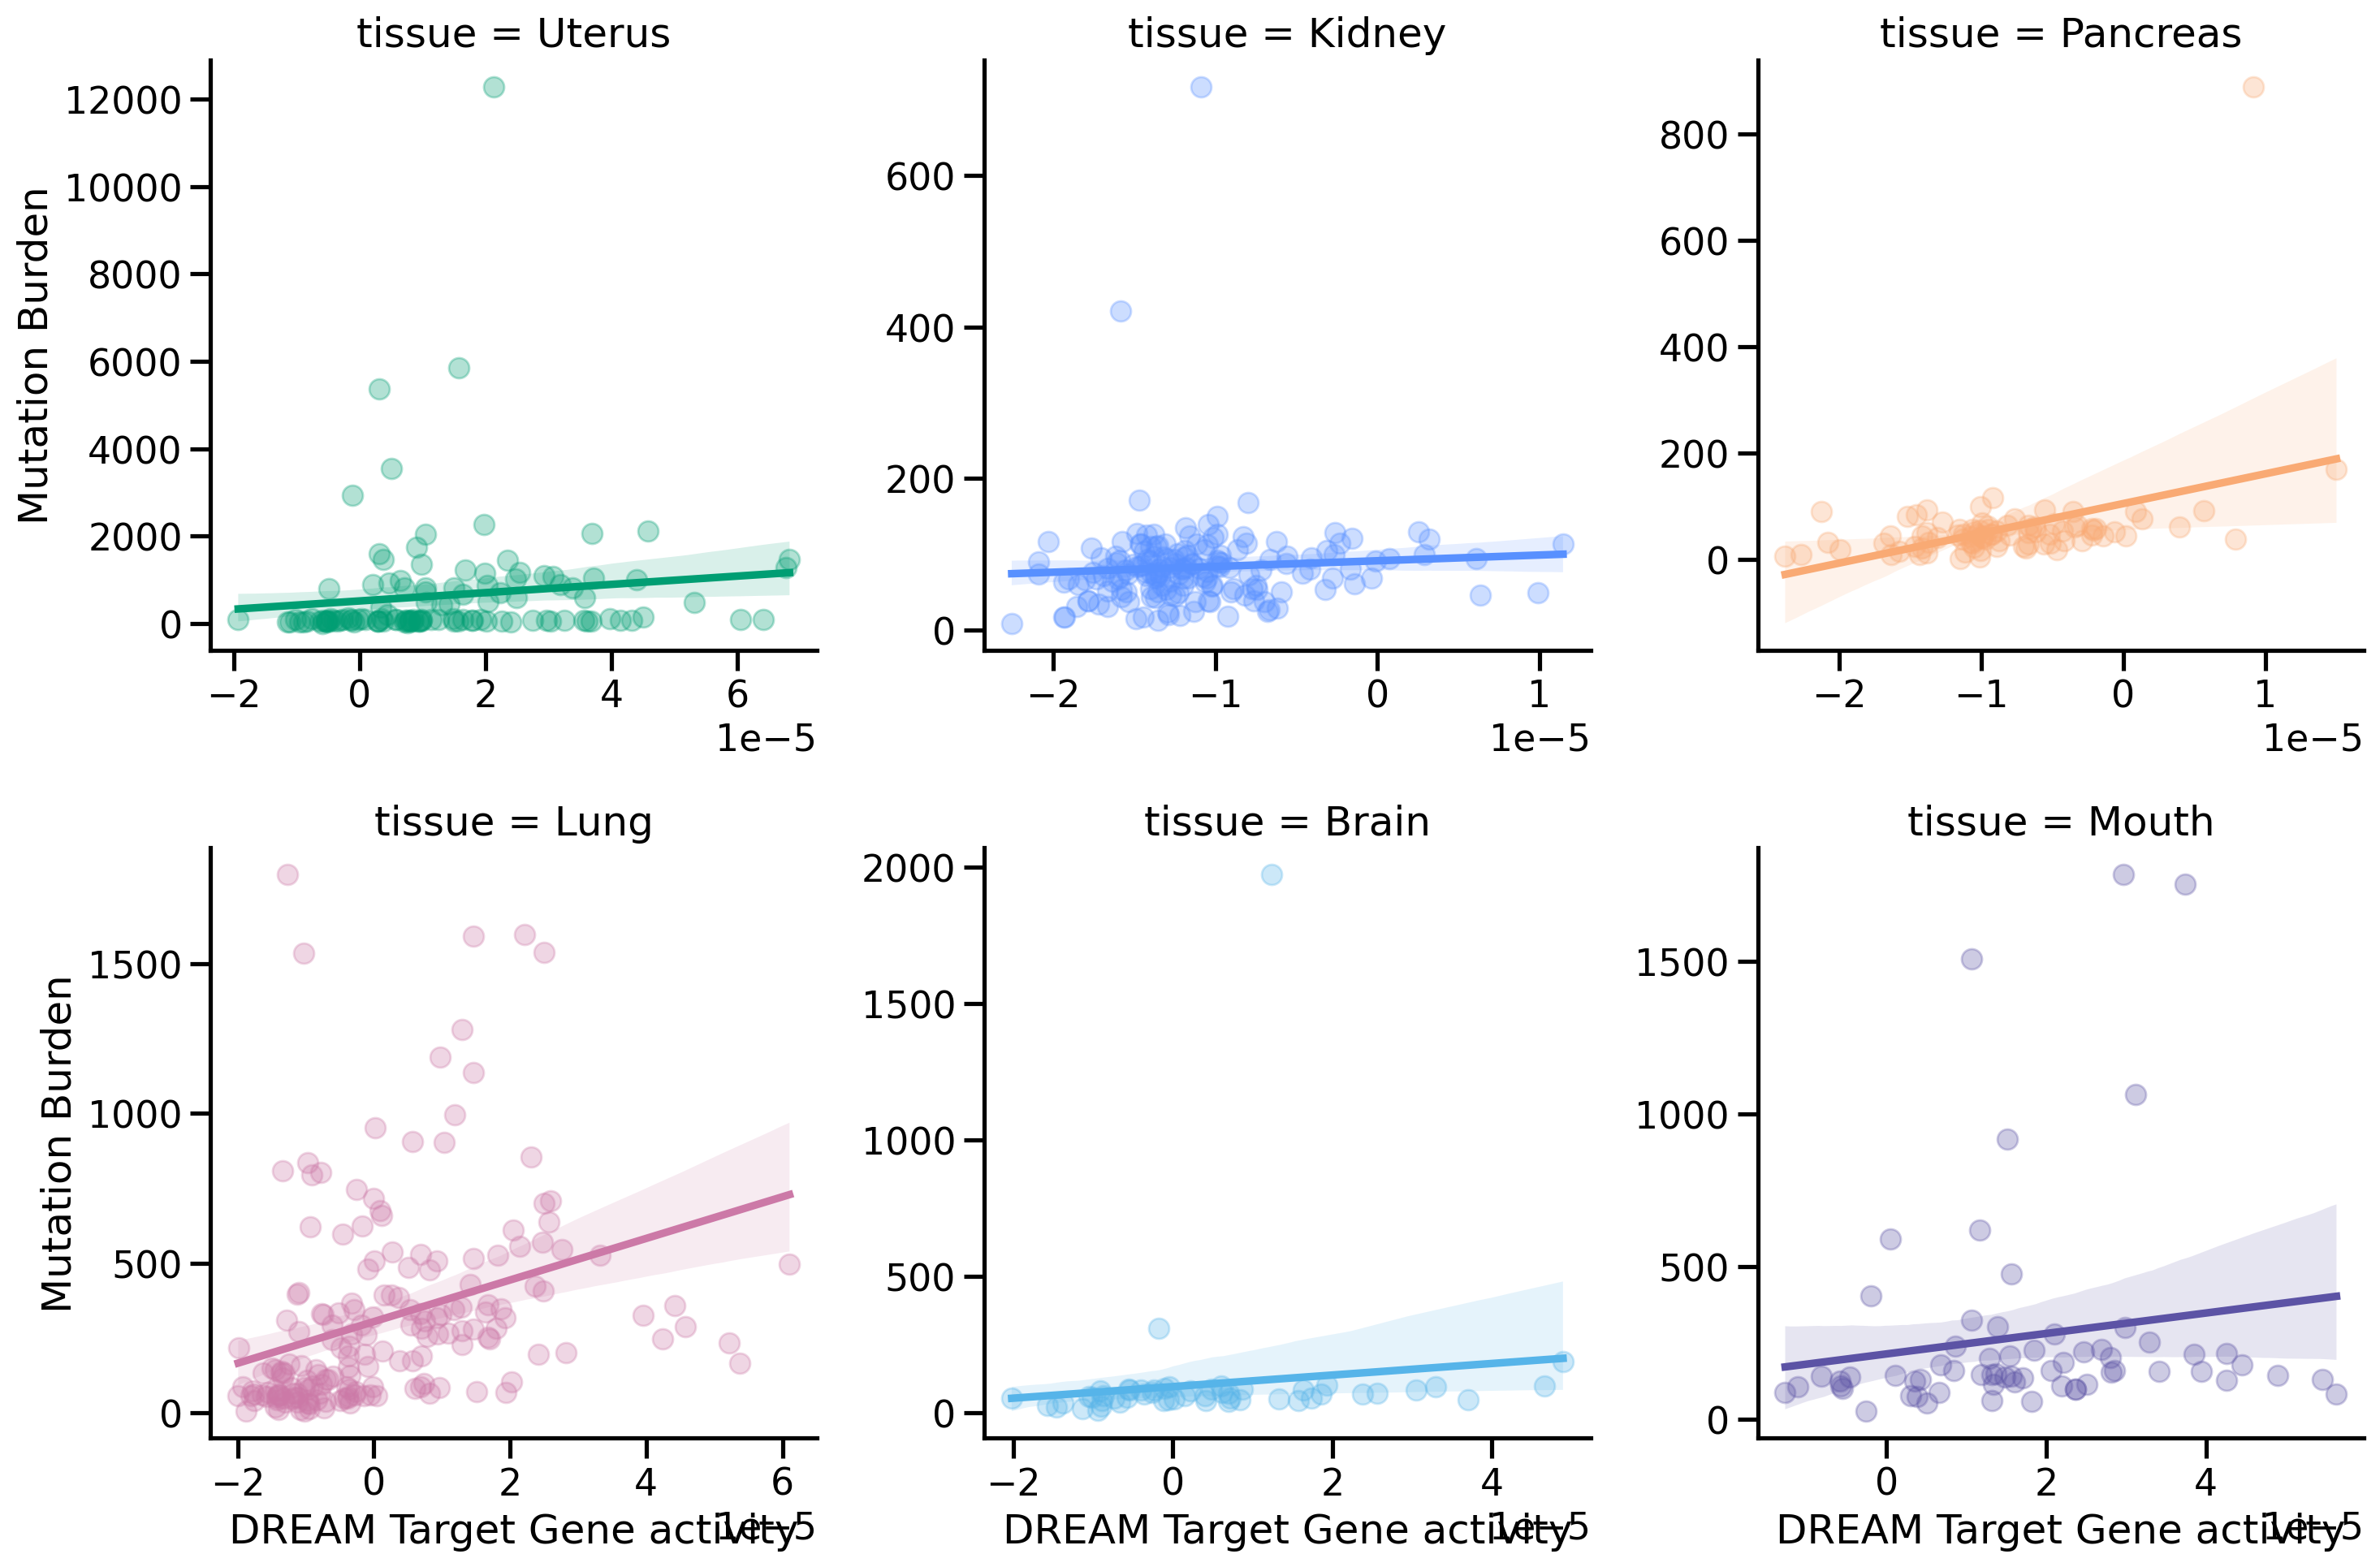

In [79]:
# get the linear equations from the regression
sns.set_context('talk')
tumor_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr_resid':'DREAM Target Gene activity'
                                    }, inplace=True)
sns.lmplot(
    data = tumor_expr_v_burden,
    x = 'DREAM Target Gene activity', y = 'Mutation Burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    col_wrap=3,
)



In [87]:
# robust linear model from formula
from statsmodels.robust.robust_linear_model import RLM
# fit robust linear model
robust_model = RLM.from_formula(' mutation_burden~ age_at_index*tissue', data=tumor_expr_v_burden)
results = robust_model.fit()

In [90]:
results.params

Intercept                          53.157737
tissue[T.Kidney]                  -46.801124
tissue[T.Lung]                    -52.467586
tissue[T.Mouth]                   -98.178715
tissue[T.Pancreas]                 -1.056912
tissue[T.Uterus]                   57.753861
age_at_index                        0.261932
age_at_index:tissue[T.Kidney]       0.889271
age_at_index:tissue[T.Lung]         3.073734
age_at_index:tissue[T.Mouth]        3.191867
age_at_index:tissue[T.Pancreas]    -0.311448
age_at_index:tissue[T.Uterus]       0.017422
dtype: float64

In [91]:
mutation_rate = {'Kidney': 0.261932 + 0.889271, 'Lung': 0.261932 + 3.073734, 'Mouth': 0.261932 + 3.191867, 'Pancreas': 0.261932 + 0.311448, 'Uterus': 0.261932 + 0.017422}

/tmp/ipykernel_348296/2556682373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden['Somatic mutation rate (per year)'] = tumor_expr_v_burden['tissue'].map(mutation_rate)


<Axes: xlabel='Somatic mutation rate (per year)', ylabel='mean_dream_reg_expr'>

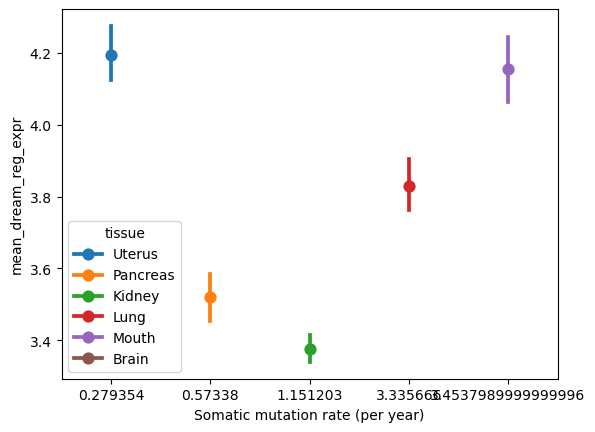

In [97]:
tumor_expr_v_burden['Somatic mutation rate (per year)'] = tumor_expr_v_burden['tissue'].map(mutation_rate)
sns.pointplot(
    data = tumor_expr_v_burden,
    x = 'Somatic mutation rate (per year)', y = 'mean_dream_reg_expr', hue = 'tissue',
)

In [99]:
normal_expr_v_burden[['Somatic mutation rate (per year)', 'mean_dream_reg_expr']].corr()

Somatic mutation rate (per year)  \
Somatic mutation rate (per year)                          1.000000   
mean_dream_reg_expr                                       0.328777   

                                  mean_dream_reg_expr  
Somatic mutation rate (per year)             0.328777  
mean_dream_reg_expr                          1.000000

<Axes: xlabel='Somatic mutation rate (per year)', ylabel='mean_dream_reg_expr'>

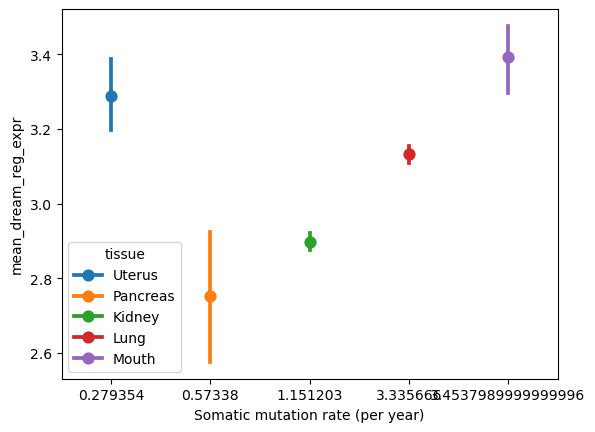

In [98]:
normal_expr_v_burden['Somatic mutation rate (per year)'] = normal_expr_v_burden['tissue'].map(mutation_rate)
sns.pointplot(
    data = normal_expr_v_burden,
    x = 'Somatic mutation rate (per year)', y = 'mean_dream_reg_expr', hue = 'tissue',
)

/tmp/ipykernel_348296/3633096871.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


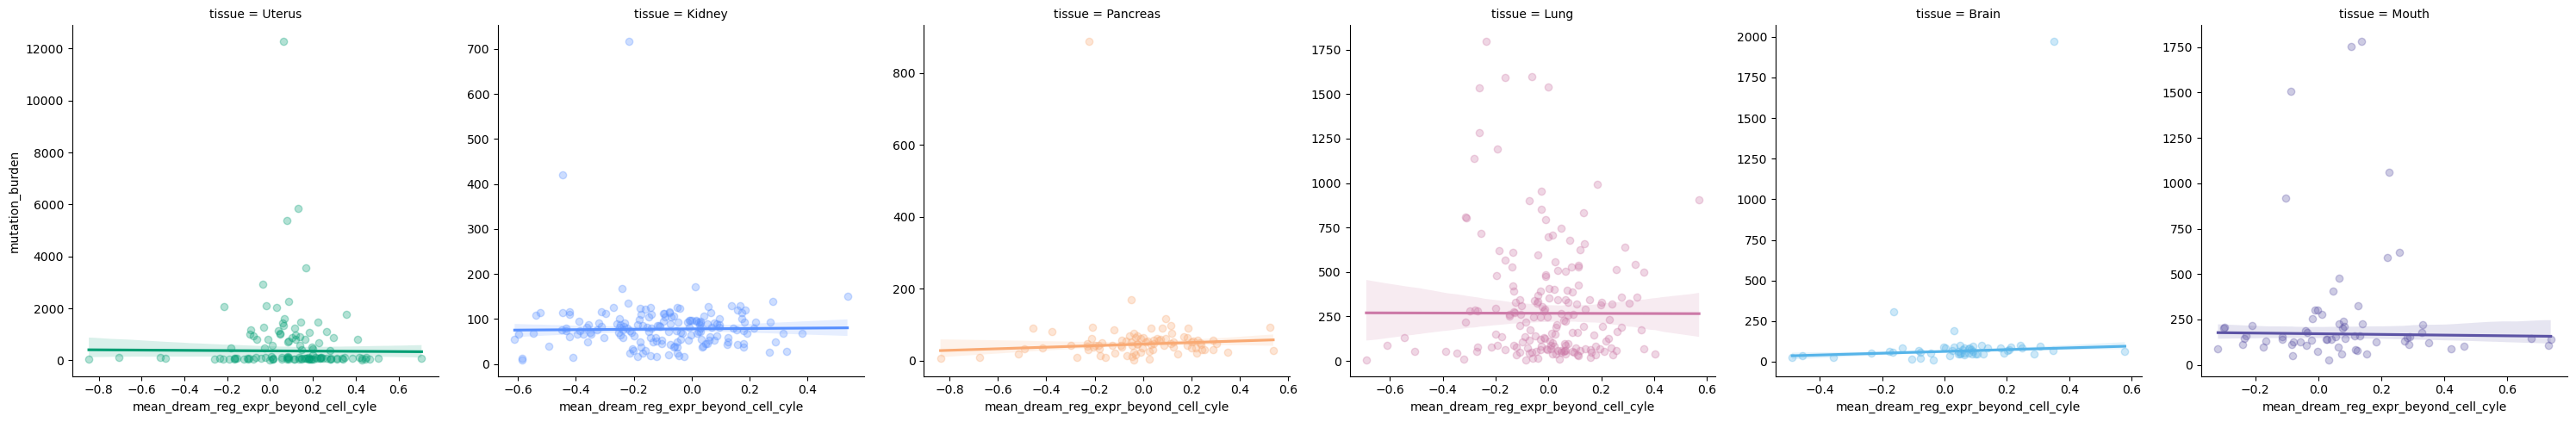

In [100]:

# control dream expression for S_score
# fit linear model
model = smf.ols(formula='mean_dream_reg_expr ~ S_score * G2M_score', data=tumor_expr_v_burden)
results = model.fit()
# add residuals to dataframe
tumor_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
sns.lmplot(
    data = tumor_expr_v_burden,
    x = 'mean_dream_reg_expr_beyond_cell_cyle', y = 'mutation_burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    robust  = True,
)

/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


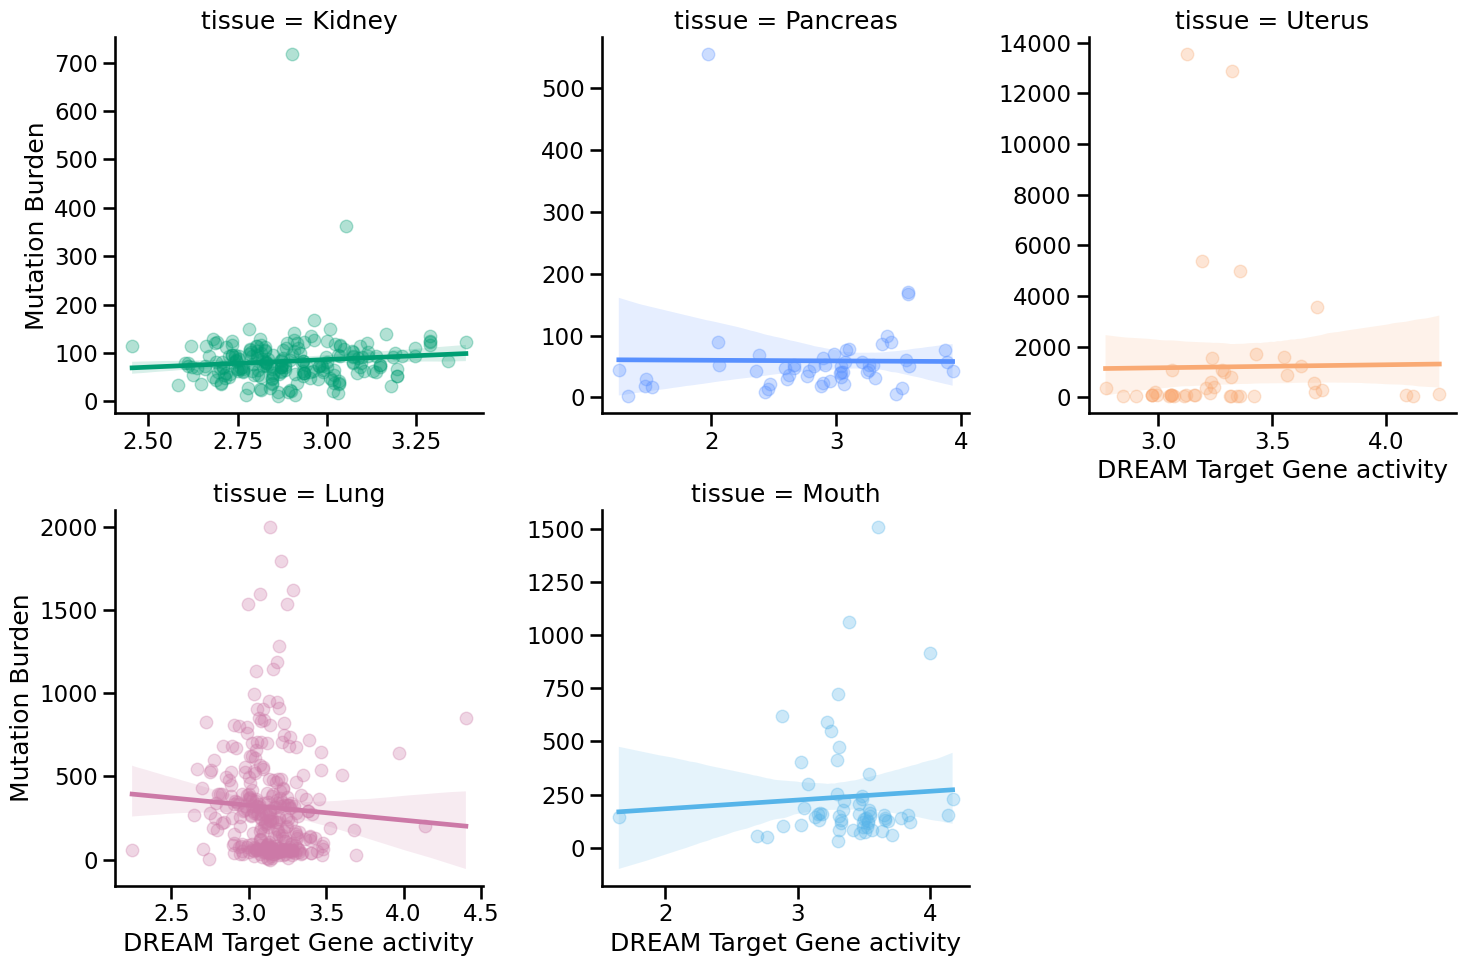

In [111]:

# get the linear equations from the regression
sns.set_context('talk')
normal_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr':'DREAM Target Gene activity'
                                    }, inplace=True)
sns.lmplot(
    data = normal_expr_v_burden,
    x = 'DREAM Target Gene activity', y = 'Mutation Burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    col_wrap=3,
)



/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


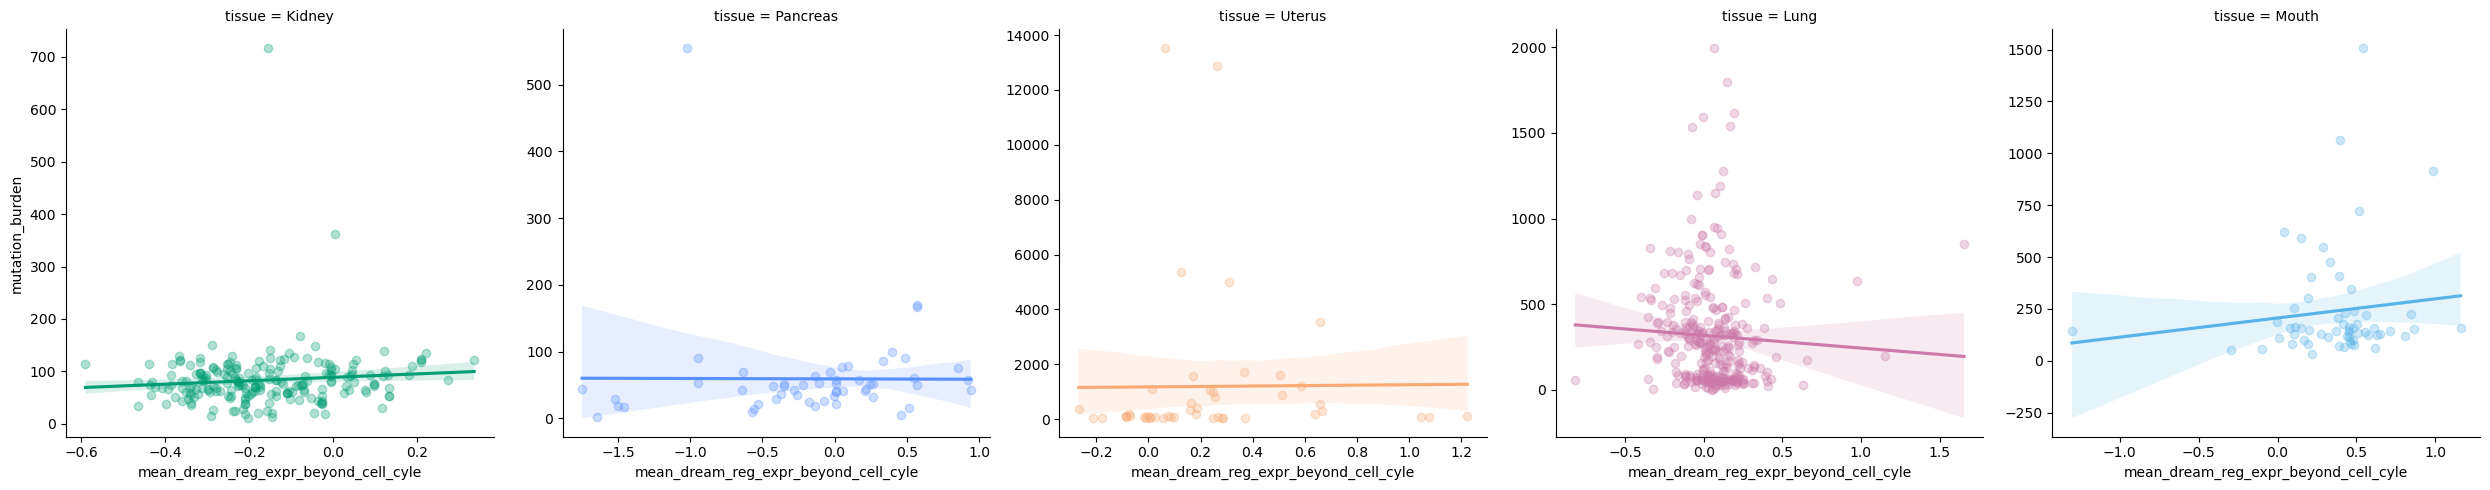

In [70]:
# control dream expression for S_score
# fit linear model
model = smf.ols(formula='mean_dream_reg_expr ~ S_score * G2M_score', data=normal_expr_v_burden)
results = model.fit()
# add residuals to dataframe
normal_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
sns.lmplot(
    data = normal_expr_v_burden,
    x = 'mean_dream_reg_expr_beyond_cell_cyle', y = 'mutation_burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
)